# <span style="color:blue;">**Brain Tumor Segmentation Project**</span>

#### **Authors**: Candice Bouquin-Renoux, Sarah Garcia, Robin Guiavarch

### **Dataset:** BraTS 2021

https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1/data

* 1251 brains (patients) in the dataset (to be split into train/validation/test).

* 3D Images (NIfTI format): The BraTS MRI scans are provided in a volumetric format (.nii.gz). This means they are not just simple 2D images but rather successive slices forming a 3D volume of the brain. Shape: 240x240x155

* Four different modalities per scan: T1, T1Gd, T2, and FLAIR.

    - BraTS2021_01431_flair.nii.gz: FLAIR MRI volume (Fluid Attenuated Inversion Recovery).
    - BraTS2021_01431_seg.nii.gz: Segmentation mask, i.e., the ground truth indicating the different tumor subregions (or absence of tumor) voxel by voxel.
    - BraTS2021_01431_t1.nii.gz: T1-weighted MRI volume.
    - BraTS2021_01431_t1ce.nii.gz: Post-contrast T1-weighted MRI volume (T1-CE).
    - BraTS2021_01431_t2.nii.gz: T2-weighted MRI volume.

* Reference masks with 4 labels:

    - "Enhancing tumor" : class 4 (switched in class 3 after)
    - "Peritumoral edema" : class 2
    - "Necrotic core" : class 1
    - "No tumor" : class 0




### **Table of Contents**

0. **Before Starting**
    - 0.a. Dataset Extraction
    - 0.b. Visualization

1. **Dataset Pre-processing**
    - 1.a. Several attempts...
    - 1.b. Final Pre-processing

2. **Segmentation with a CNN UNet Model**
    - 2.a. Dataset preparation
    - 2.b. Model Definition
    - 2.c. Definition of IoU and Dice Metrics
    - 2.d. Definition of the Dice Loss
    - 2.e. Model Training
    - 2.f. Learning Curves
    - 2.g. Results (IoU + Dice, 4 examples with confidence map and predicted masks)

3. **Calibration of the CNN UNet Model**
    - 3.a. ECE Metric
    - 3.b. Temperature Scaling
    - 3.c. Adaptive Temperature Scaling
    - 3.d. Monte Carlo Dropout

4. **Segmentation with a BNN UNet Model**
    - 4.a. Model Definition
    - 4.b. Model Training
    - 4.c. Learning Curve
    - 4.d. Results (IoU + Dice, 4 examples with confidence map + uncertainty map and predicted masks)


### **0. Before starting**

In [ ]:
import os
import tarfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

#### **0.a. Extracting dataset**

In [ ]:
##########################################################
# 1) EXTRACTING THE .tar FILE TO THE EXTERNAL HARD DRIVE
##########################################################

tar_file_path = "/Volumes/Untitled/BraTS2021_Training_Data.tar"
extract_folder = "/Volumes/Untitled/BraTS2021_extracted"

# Create the extraction folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

print(f"Extracting {tar_file_path} to {extract_folder} ...")
with tarfile.open(tar_file_path, "r") as tar:
    tar.extractall(path=extract_folder)
print("Extraction completed.")

Extraction de /Volumes/Untitled/BraTS2021_Training_Data.tar vers /Volumes/Untitled/BraTS2021_extracted ...
Extraction terminée.


#### **0.b. Dataset vizualisation**

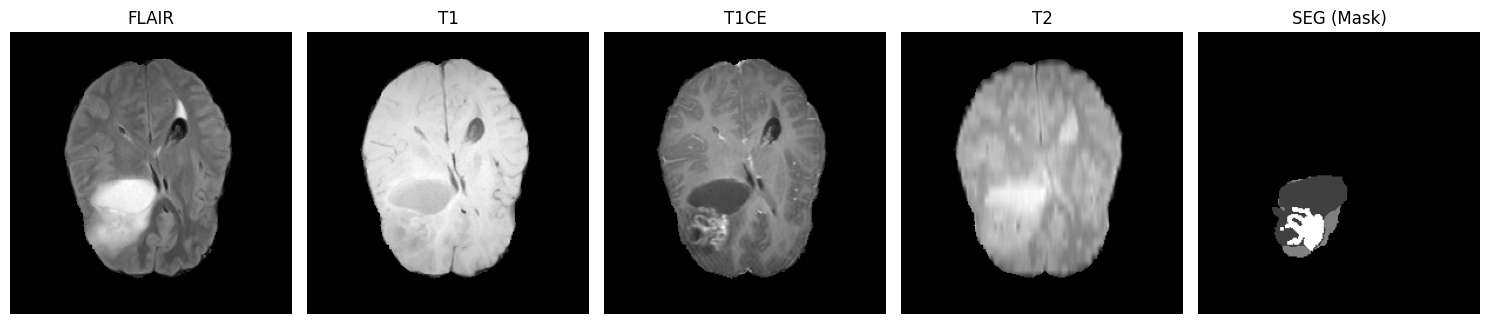

In [ ]:
# -------------------------------------------------------------------
# 1) Loading NIfTI volumes (FLAIR, T1, T1ce, T2, SEG) for a patient
# -------------------------------------------------------------------

base_path = "/Volumes/Untitled/BraTS2021_extracted/BraTS2021_01532/"

path_flair = base_path + "BraTS2021_01532_flair.nii.gz"
path_t1 = base_path + "BraTS2021_01532_t1.nii.gz"
path_t1ce = base_path + "BraTS2021_01532_t1ce.nii.gz"
path_t2 = base_path + "BraTS2021_01532_t2.nii.gz"
path_seg = base_path + "BraTS2021_01532_seg.nii.gz"

# Loading via nibabel
img_flair = nib.load(path_flair)
data_flair = img_flair.get_fdata()

img_t1 = nib.load(path_t1)
data_t1 = img_t1.get_fdata()

img_t1ce = nib.load(path_t1ce)
data_t1ce = img_t1ce.get_fdata()

img_t2 = nib.load(path_t2)
data_t2 = img_t2.get_fdata()

img_seg = nib.load(path_seg)
data_seg = img_seg.get_fdata()

# -------------------------------------------------------------------
# 2) Selecting an axial slice at Z=70
# -------------------------------------------------------------------
slice_index = 70

slice_flair = data_flair[:, :, slice_index]
slice_t1 = data_t1[:, :, slice_index]
slice_t1ce = data_t1ce[:, :, slice_index]
slice_t2 = data_t2[:, :, slice_index]
slice_seg = data_seg[:, :, slice_index]

# -------------------------------------------------------------------
# 3) Displaying the 5 images side by side
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(slice_flair.T, cmap="gray", origin="lower")
axes[0].set_title("FLAIR")
axes[0].axis("off")

axes[1].imshow(slice_t1.T, cmap="gray", origin="lower")
axes[1].set_title("T1")
axes[1].axis("off")

axes[2].imshow(slice_t1ce.T, cmap="gray", origin="lower")
axes[2].set_title("T1CE")
axes[2].axis("off")

axes[3].imshow(slice_t2.T, cmap="gray", origin="lower")
axes[3].set_title("T2")
axes[3].axis("off")

axes[4].imshow(slice_seg.T, cmap="gray", origin="lower")
axes[4].set_title("SEG (Mask)")
axes[4].axis("off")

plt.tight_layout()
plt.show()


### **1. Dataset Pre-processing**

The core of our study is neither to provide a 3D segmentation nor to achieve the best possible segmentation.  
Our project focuses on **calibration and uncertainty quantification of neural networks**.

Thus, for training time constraints, we have made the following choices:

* Perform **2D segmentation** on multiple brain slices instead of 3D.
* Retain only the **T1CE modality** and the reference mask.
* Resize images to **128x128** format.
* Select only **9 slices** taken from the middle of the brain tumor, perpendicular to the Z-axis.

For reference, many other pre-processed datasets were tested, including keeping all **five modalities** and using **more slices**.  
However, computational constraints have repeatedly limited our ability to proceed.


In [ ]:
import numpy as np
import os
import nibabel as nib
import shutil
import random
from skimage.transform import resize
import glob
from skimage import exposure

#### **1.a. Min-Max normalization**

**Objective:** Ensure consistent value scales.

In [ ]:
def preprocess_minmax_normalization(nifti_img):
    """
    Applies Min-Max normalization [0,1] to intensity values
    (for MRI volumes, excluding masks).
    """
    data = nifti_img.get_fdata()
    min_val, max_val = np.min(data), np.max(data)

    # Avoid division by zero if the image has constant intensity
    if max_val - min_val > 1e-8:
        data = (data - min_val) / (max_val - min_val)
    else:
        # Case of a flat image: keep it at zero
        data = np.zeros_like(data)

    return data  # Returns a NumPy array


In [ ]:
# Source and destination directories
SOURCE_DIR = "/Volumes/Untitled/BraTS2021_extracted"
OUTPUT_DIR = "/Volumes/Untitled/BraTS2021_preprocessed_0"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def process_patient(patient_dir, output_dir):
    """
    - Retrieves the 5 MRI volumes (FLAIR, T1, T1CE, T2, SEG) for a patient.
    - Applies:
        1) Min-Max normalization on MRI scans (excluding the segmentation mask).
        2) Saves the processed volumes in the output_dir
           while preserving the same folder structure.
    """
    patient_id = os.path.basename(patient_dir)  # e.g., "BraTS2021_01431"
    output_patient_dir = os.path.join(output_dir, patient_id)
    os.makedirs(output_patient_dir, exist_ok=True)

    # Expected modalities
    modalities = ["flair", "t1", "t1ce", "t2", "seg"]

    for mod in modalities:
        input_path = os.path.join(patient_dir, f"{patient_id}_{mod}.nii.gz")

        # Check if the file exists
        if not os.path.isfile(input_path):
            print(f"[WARNING] Missing file: {mod} for {patient_id}")
            continue

        print(f"Processing {input_path} ...")

        # Load the volume
        nifti_in = nib.load(input_path)
        data_3d = nifti_in.get_fdata()
        affine = nifti_in.affine

        # Detect if it is a segmentation mask
        is_mask = mod == "seg"

        # 1) Min-Max normalization (only for MRI scans, not for the mask)
        if not is_mask:
            data_3d = preprocess_minmax_normalization(nifti_in)
        # Otherwise, keep "data_3d" unchanged for the mask

        # 2) Create a new NIfTI file
        nifti_out = nib.Nifti1Image(data_3d, affine)

        # Output path
        output_path = os.path.join(output_patient_dir, f"{patient_id}_{mod}.nii.gz")
        nib.save(nifti_out, output_path)

        print(f"[OK] Saved: {output_path}")


def run_preprocessing():
    """
    - Retrieves all patient folders of the form "BraTS2021_xxxxx".
    - Processes each patient folder individually.
    """
    patient_folders = [
        os.path.join(SOURCE_DIR, d) for d in os.listdir(SOURCE_DIR)
        if d.startswith("BraTS2021_") and os.path.isdir(os.path.join(SOURCE_DIR, d))
    ]

    # Process each patient
    for p_dir in patient_folders:
        process_patient(p_dir, OUTPUT_DIR)


run_preprocessing()


#### **1.b Dataset split TRAIN/VAL/TEST**

* Train (60%): 751 patients.
* Val (20%): 250 patients.
* Test (20%): 251 patients.


In [ ]:
# Root directory containing the 1251 preprocessed patient folders
SOURCE_DIR = "/Volumes/Untitled/BraTS2021_preprocessed_0"

# Output directories
TRAIN_DIR = os.path.join(SOURCE_DIR, "BraTS2021_train")
VAL_DIR = os.path.join(SOURCE_DIR, "BraTS2021_val")
TEST_DIR = os.path.join(SOURCE_DIR, "BraTS2021_test")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Retrieve all patient folders (BraTS2021_XXXXX)
all_patients = [
    d for d in os.listdir(SOURCE_DIR)
    if d.startswith("BraTS2021_") and os.path.isdir(os.path.join(SOURCE_DIR, d))
]

# Shuffle randomly
random.shuffle(all_patients)

n_total = len(all_patients)
n_train = int(0.60 * n_total)
n_val = int(0.20 * n_total)
n_test = n_total - n_train - n_val  # Ensures full inclusion, avoids rounding errors

train_patients = all_patients[:n_train]
val_patients = all_patients[n_train:n_train + n_val]
test_patients = all_patients[n_train + n_val:]

print(f"Total: {n_total} patients")
print(f"Train: {len(train_patients)} patients")
print(f"Val:   {len(val_patients)} patients")
print(f"Test:  {len(test_patients)} patients")


def move_patients(patient_list, dest_dir):
    """
    Moves the entire patient directories to the specified destination.
    """
    for p in patient_list:
        src_path = os.path.join(SOURCE_DIR, p)
        dst_path = os.path.join(dest_dir, p)
        shutil.move(src_path, dst_path)  # Move the entire folder


# Move the patient directories
move_patients(train_patients, TRAIN_DIR)
move_patients(val_patients, VAL_DIR)
move_patients(test_patients, TEST_DIR)

print("Dataset split completed.")


#### **1.c Resizing NIfTI volumes to 128x128x128 + Keeping only T1ce and seg (reference mask)**

In [ ]:
def resize_volume_xyz(data_3d, target_shape=(256, 256, 128), is_mask=False):
    """
    Resizes a 3D volume from (X, Y, Z) to target_shape (newX, newY, newZ)
    using skimage.transform.resize (3D interpolation).

    - is_mask=True  => nearest neighbor (order=0), anti_aliasing=False
    - is_mask=False => bilinear (order=1), anti_aliasing=True
    """

    if is_mask:
        # For a mask (discrete labels)
        data_resized = resize(
            data_3d,
            output_shape=target_shape,
            order=0,               # nearest neighbor
            mode="edge",
            preserve_range=True,
            anti_aliasing=False
        )
    else:
        # For an MRI volume (continuous intensity values)
        data_resized = resize(
            data_3d,
            output_shape=target_shape,
            order=1,               # bilinear
            mode="edge",
            preserve_range=True,
            anti_aliasing=True
        )

    return data_resized.astype(np.float32)


In [ ]:
def process_patient_v2(patient_dir, output_root):
    """
    - Retrieves the two volumes (T1CE, SEG) for a patient.
    - Applies:
        1) 3D resizing.
        2) Saves the processed volumes in the output_root directory,
           maintaining the same folder structure
           (train / val / test / BraTS2021_xxxxx / ...).
    """
    # parent_folder = "BraTS2021_train", "BraTS2021_val", or "BraTS2021_test"
    parent_folder = os.path.basename(os.path.dirname(patient_dir))
    # patient_id = "BraTS2021_01431"
    patient_id = os.path.basename(patient_dir)

    # Create the full output directory
    # [output_root]/[BraTS2021_train]/[BraTS2021_01431]
    output_patient_dir = os.path.join(output_root, parent_folder, patient_id)
    os.makedirs(output_patient_dir, exist_ok=True)

    # Expected modalities
    modalities = ["t1ce", "seg"]

    for mod in modalities:
        input_path = os.path.join(patient_dir, f"{patient_id}_{mod}.nii.gz")

        # Check if the file exists
        if not os.path.isfile(input_path):
            print(f"[WARNING] Missing file: {mod} for {patient_id}")
            continue

        print(f"Processing {input_path} ...")

        # Load the volume
        nifti_in = nib.load(input_path)
        data_3d = nifti_in.get_fdata()
        affine = nifti_in.affine

        # Detect if it is a segmentation mask
        is_mask = mod == "seg"

        # 2) Resizing (calls the existing resize_volume_xyz function)
        data_resized = resize_volume_xyz(
            data_3d,
            target_shape=(128, 128, 128),
            is_mask=is_mask
        )

        # 3) Create a new NIfTI file
        nifti_out = nib.Nifti1Image(data_resized, affine)

        # Output path
        output_path = os.path.join(output_patient_dir, f"{patient_id}_{mod}.nii.gz")
        nib.save(nifti_out, output_path)

        print(f"[OK] Saved: {output_path}")


In [ ]:
dataset_root = "/Volumes/Untitled/BraTS2021_preprocessed_1"  # Path to the three subdirectories
output_root = "/Volumes/Untitled/BraTS2021_preprocessed_2"

# List all patient directories in train/val/test
patient_dirs = glob.glob(os.path.join(dataset_root, "BraTS2021_*", "BraTS2021_*"))
# Example: "/content/dataset/BraTS2021_preprocessed/BraTS2021_train/BraTS2021_00001"

for pdir in patient_dirs:
    process_patient_v2(pdir, output_root)


#### **1.d Extraction of 9 slices along the Z-axis at the tumor center.**

When selecting random slices among the 128 in the resulting NIfTI volume (128x128x128), segmentation results were particularly poor. Many slices without tumors were selected, leading to a strong predominance of class 0 ("no tumor").

To reduce this class imbalance, we decided to extract 9 slices from the center of the tumor for each brain.

![9 Slices extracted](9_slices.png)

In [ ]:
def process_patient_slices_tumorcenter(patient_dir, output_root, num_slices=9):
    """
    For a given patient, locate the interval [z_min, z_max] in the segmentation mask (seg)
    where the tumor is present (values != 0).
    Compute the center: mid = (z_min + z_max) // 2.
    Then, select a total of num_slices (e.g., 9) around this midpoint:
      - 4 slices below, 1 in the middle, 4 above.
      - Ensure the selection stays within the valid range [0, shape[2]-1].

    Apply the same selection to both the T1ce modality and the segmentation mask (seg).
    Save the results in output_root while maintaining the same directory structure.
    """

    parent_folder = os.path.basename(os.path.dirname(patient_dir))
    patient_id = os.path.basename(patient_dir)

    # Output directory for this patient
    output_patient_dir = os.path.join(output_root, parent_folder, patient_id)
    os.makedirs(output_patient_dir, exist_ok=True)

    # 1) Load the segmentation mask (seg)
    seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii.gz")
    if not os.path.isfile(seg_path):
        print(f"[WARNING] Missing segmentation mask for {patient_id}. Skipping.")
        return

    seg_nifti = nib.load(seg_path)
    seg_data = seg_nifti.get_fdata()  # Expected shape: (128, 128, 128)
    affine = seg_nifti.affine

    # 2) Find z_min, z_max where the tumor is present
    #    Identify all nonzero voxels
    nonzero_coords = np.argwhere(seg_data != 0)
    if nonzero_coords.size == 0:
        # Case where no tumor is detected in this volume (all values = 0)
        print(f"[INFO] No tumor detected for {patient_id}. Skipping.")
        return

    z_min = nonzero_coords[:, 2].min()
    z_max = nonzero_coords[:, 2].max()

    # 3) Compute the middle slice
    z_mid = (z_min + z_max) // 2

    # 4) Determine the list of slices
    #    Example: if num_slices=9, select z_mid-4 to z_mid+4
    half = (num_slices - 1) // 2  # e.g., 4 if num_slices=9
    z_start = z_mid - half
    z_end = z_mid + half

    slice_indices = list(range(z_start, z_end + 1))
    # Clip to stay within valid range [0, shape_z-1]
    max_z = seg_data.shape[2] - 1
    slice_indices = [z for z in slice_indices if 0 <= z <= max_z]

    # 5) Apply this selection to (T1ce and seg)
    modalities = ["t1ce", "seg"]
    for mod in modalities:
        input_path = os.path.join(patient_dir, f"{patient_id}_{mod}.nii.gz")
        if not os.path.isfile(input_path):
            print(f"[WARNING] Missing file: {mod} for {patient_id}")
            continue

        print(f"Processing {input_path} ...")
        nifti_in = nib.load(input_path)
        data_3d = nifti_in.get_fdata()

        # Extract selected slices
        data_reduced = data_3d[:, :, slice_indices]

        # Create new NIfTI file and save
        nifti_out = nib.Nifti1Image(data_reduced, affine)
        output_path = os.path.join(output_patient_dir, f"{patient_id}_{mod}.nii.gz")
        nib.save(nifti_out, output_path)
        print(f"[OK] Saved: {output_path}")


def process_dataset_tumorcenter(input_root, output_root, num_slices=9):
    """
    Iterates through all patient directories in BraTS2021_train, BraTS2021_val, BraTS2021_test,
    and applies process_patient_slices_tumorcenter to each.
    """
    for subset in ["BraTS2021_train", "BraTS2021_val", "BraTS2021_test"]:
        subset_dir = os.path.join(input_root, subset)
        if not os.path.isdir(subset_dir):
            print(f"[WARNING] Folder {subset_dir} not found.")
            continue

        for patient_id in sorted(os.listdir(subset_dir)):
            patient_dir = os.path.join(subset_dir, patient_id)
            if os.path.isdir(patient_dir):
                process_patient_slices_tumorcenter(patient_dir, output_root, num_slices=num_slices)


input_root = "/Volumes/Untitled/BraTS2021_preprocessed_2"
output_root = "/Volumes/Untitled/BraTS2021_preprocessed_5"

process_dataset_tumorcenter(input_root, output_root, num_slices=9)


#### **1.e. Cropping + Gamma Adjustment + Resize 128x128x9**


##### **Cropping**

To further reduce class imbalance, we aimed to minimize the black background surrounding the brain scans. To achieve this, we:

- Defined a grayscale threshold below which a pixel is considered part of the black background.
- Identified the largest bounding box encompassing all brain images from all patients in the dataset.


In [ ]:
def plot_random_t1ce_slice(
    input_root, subsets=("BraTS2021_train", "BraTS2021_val", "BraTS2021_test")
):
    """
    1. Randomly selects a subset (train/val/test).
    2. Selects a patient and loads the T1ce volume.
    3. Randomly selects a slice (Z).
    4. Displays the slice on the left and its intensity histogram on the right.
    """
    # Randomly choose a subset from train/val/test
    chosen_subset = random.choice(subsets)
    subset_dir = os.path.join(input_root, chosen_subset)

    # List patients in this subset
    patients = [p for p in os.listdir(subset_dir) if os.path.isdir(os.path.join(subset_dir, p))]
    if not patients:
        print(f"[WARNING] No data found in {subset_dir}")
        return

    # Randomly choose a patient
    patient_id = random.choice(patients)
    patient_dir = os.path.join(subset_dir, patient_id)

    # T1ce path
    t1ce_path = os.path.join(patient_dir, f"{patient_id}_t1ce.nii.gz")
    if not os.path.isfile(t1ce_path):
        print(f"[WARNING] No T1ce found for {patient_id}")
        return

    # Load the T1ce volume
    nifti_img = nib.load(t1ce_path)
    data_3d = nifti_img.get_fdata()  # shape: (X, Y, Z)

    # Randomly select a Z slice
    max_z = data_3d.shape[2]
    z_idx = random.randint(0, max_z - 1)
    slice_2d = data_3d[:, :, z_idx]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Left subplot: T1ce slice
    axes[0].imshow(slice_2d, cmap="gray")
    axes[0].set_title(
        f"T1ce Slice\nSubset: {chosen_subset} | Patient: {patient_id} | Z={z_idx}"
    )
    axes[0].axis("off")

    # Right subplot: intensity histogram
    axes[1].hist(slice_2d.flatten(), bins=100, color="blue", alpha=0.7)
    axes[1].set_title("Intensity Histogram (this slice)")
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


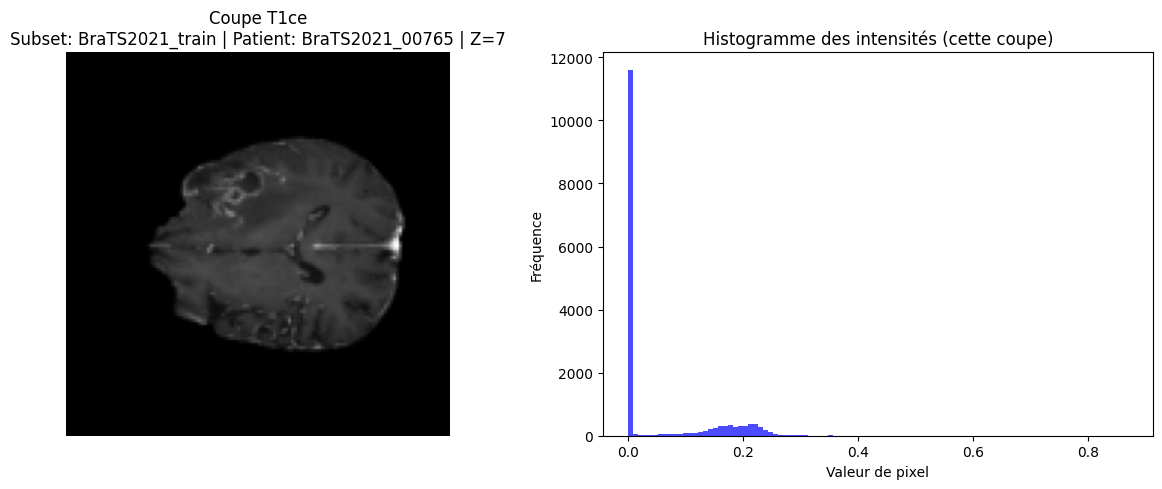

In [ ]:
input_root = "/Volumes/Untitled/BraTS2021_preprocessed_5"

# Calling many time to analyse many histograms
plot_random_t1ce_slice(input_root)

##### <span style="color: green;">**Comment:**</span>

Based on some random histograms, we will choose a threshold of 0.08, below which the pixel is considered as a black background.





In [ ]:
def find_global_bounding_box(
    input_root,
    subset_list=("BraTS2021_train", "BraTS2021_val", "BraTS2021_test"),
    modality="t1ce",
    threshold=0.08,
):
    """
    Iterates through all patients in (train, val, test) within input_root,
    loads the T1ce volume,
    finds the bounding box (x_min, x_max, y_min, y_max) that encompasses the entire 'brain'
    based on a threshold to remove the black background.

    Returns (x_min, x_max, y_min, y_max).
    """
    x_min_global = 99999
    x_max_global = 0
    y_min_global = 99999
    y_max_global = 0

    for subset in subset_list:
        subset_dir = os.path.join(input_root, subset)
        if not os.path.isdir(subset_dir):
            print(f"[WARNING] Folder {subset_dir} not found, skipping.")
            continue

        for patient_id in os.listdir(subset_dir):
            patient_dir = os.path.join(subset_dir, patient_id)
            if not os.path.isdir(patient_dir):
                continue

            t1ce_path = os.path.join(patient_dir, f"{patient_id}_{modality}.nii.gz")
            if not os.path.isfile(t1ce_path):
                continue

            # Load the T1ce volume
            nifti_img = nib.load(t1ce_path)
            data_3d = nifti_img.get_fdata()  # shape (X, Y, Z)

            # Find indices where data > threshold
            coords = np.argwhere(data_3d > threshold)
            if coords.size == 0:
                # Everything is below the threshold => skip
                continue

            x_vals = coords[:, 0]
            y_vals = coords[:, 1]
            # z_vals = coords[:, 2]  # Not needed for the XY bounding box

            local_x_min = x_vals.min()
            local_x_max = x_vals.max()
            local_y_min = y_vals.min()
            local_y_max = y_vals.max()

            # Update global bounding box
            if local_x_min < x_min_global:
                x_min_global = local_x_min
            if local_x_max > x_max_global:
                x_max_global = local_x_max
            if local_y_min < y_min_global:
                y_min_global = local_y_min
            if local_y_max > y_max_global:
                y_max_global = local_y_max

    return x_min_global, x_max_global, y_min_global, y_max_global


##### **Gamma Adjustment**

Gamma adjustment modifies the distribution of grayscale levels in a nonlinear manner, unlike simple linear normalization (min-max). When applying exposure.adjust_gamma(data, gamma=value), it primarily changes how the dark or bright areas of the image are represented:

* If gamma > 1:

Dark areas become even darker (the grayscale curve is “stretched” downward for low intensities).
Bright areas are slightly less affected, which enhances contrast in low-intensity regions.

* If gamma < 1:

Dark areas are slightly “lifted” (they become less dark).
High intensities are less modified, which helps reveal more details in the darker parts of the spectrum.

**Application in Tumor Segmentation:**

This type of gamma correction can help highlight tumor regions if they fall within an intensity range that needs to be emphasized or better contrasted. For instance, in a T2 or FLAIR sequence, a tumor may have a slightly higher intensity than healthy tissue but may not be very bright. By increasing the gamma, we enhance the nuances in this part of the spectrum, making it more distinct from the surrounding tissue.

**Improving Model Robustness through Data Augmentation:**

MRI scans can vary slightly in brightness due to differences in imaging devices, patients, etc. By applying different gamma adjustments, we expose the neural network to variations in lighting (intensity), making it more capable of generalizing to images with different intensity histograms.

Thus, adjusting brightness (or more precisely, the intensity distribution) using adjust_gamma is a simple and controlled way to modulate the visibility of structures of interest (including tumors) and enrich the dataset without resorting to overly complex transformations.

In [ ]:
def preprocess_nifti(img, brightness_factor=2):
    """
    Gamma adjustment.
    """
    data = img.get_fdata()
    data_adjusted = exposure.adjust_gamma(data, gamma=brightness_factor)
    img_preprocessed = nib.Nifti1Image(data_adjusted, img.affine)
    return img_preprocessed

##### **Preprocessing pipeline**

In [ ]:
def resize_volume_xyz(data_3d, target_shape=(128, 128, 9), is_mask=False):
    """
    Resizing 3D volume (X, Y, Z) to new target_shape (newX, newY, newZ).
    """
    if is_mask:
        # nearest neighbor
        data_resized = resize(
            data_3d,
            output_shape=target_shape,
            order=0,
            mode='edge',
            preserve_range=True,
            anti_aliasing=False
        )
    else:
        # bilinear
        data_resized = resize(
            data_3d,
            output_shape=target_shape,
            order=1,
            mode='edge',
            preserve_range=True,
            anti_aliasing=True
        )
    return data_resized.astype(np.float32)

In [ ]:
def crop_and_resize_volume(
    nifti_img, x_min, x_max, y_min, y_max, target_shape=(128, 128, 9), is_mask=False, brightness_factor=None
):
    """
    1) Apply gamma adjustment (if brightness_factor is not None).
    2) Crop to [x_min:x_max+1, y_min:y_max+1, :].
    3) Resize to target_shape.

    Returns a Nifti1Image.
    """
    data_3d = nifti_img.get_fdata()

    # (1) Gamma adjustment
    if brightness_factor is not None:
        data_3d = exposure.adjust_gamma(data_3d, gamma=brightness_factor)

    # (2) Cropping
    data_cropped = data_3d[x_min:x_max + 1, y_min:y_max + 1, :]

    # (3) Resizing
    # Assuming target_shape is (128, 128, newZ).
    data_resized = resize_volume_xyz(data_cropped, target_shape=target_shape, is_mask=is_mask)

    # Create a new Nifti image
    new_nifti = nib.Nifti1Image(data_resized, nifti_img.affine)
    return new_nifti


In [ ]:
def run_preprocessing_pipeline(
    input_root,
    output_root,
    x_min,
    x_max,
    y_min,
    y_max,
    subset_list=("BraTS2021_train", "BraTS2021_val", "BraTS2021_test"),
    t1ce_target_shape=(128, 128, 9),
    seg_target_shape=(128, 128, 9),
):
    """
    For each patient in (train, val, test):
      - Load T1ce
      - Crop => Resize => Save
      - Load segmentation
      - Crop => Resize => Save (no gamma adjustment)
    """
    for subset in subset_list:
        subset_dir = os.path.join(input_root, subset)
        if not os.path.isdir(subset_dir):
            print(f"[WARNING] Folder {subset_dir} not found, skipping.")
            continue

        for patient_id in os.listdir(subset_dir):
            patient_dir = os.path.join(subset_dir, patient_id)
            if not os.path.isdir(patient_dir):
                continue

            # T1ce path
            t1ce_path = os.path.join(patient_dir, f"{patient_id}_t1ce.nii.gz")
            # Segmentation path
            seg_path = os.path.join(patient_dir, f"{patient_id}_seg.nii.gz")

            # Prepare a corresponding output directory
            out_patient_dir = os.path.join(output_root, subset, patient_id)
            os.makedirs(out_patient_dir, exist_ok=True)

            # T1ce processing
            if os.path.isfile(t1ce_path):
                img_t1 = nib.load(t1ce_path)
                # Crop + resize + gamma adjustment
                t1_preprocessed = crop_and_resize_volume(
                    img_t1,
                    x_min,
                    x_max,
                    y_min,
                    y_max,
                    target_shape=t1ce_target_shape,
                    is_mask=False,
                )
                out_t1_path = os.path.join(out_patient_dir, f"{patient_id}_t1ce.nii.gz")
                nib.save(t1_preprocessed, out_t1_path)
                print("[OK] T1ce saved:", out_t1_path)

            # Segmentation processing
            if os.path.isfile(seg_path):
                img_seg = nib.load(seg_path)
                # Crop + resize (no gamma adjustment, is_mask=True)
                seg_preprocessed = crop_and_resize_volume(
                    img_seg,
                    x_min,
                    x_max,
                    y_min,
                    y_max,
                    target_shape=seg_target_shape,
                    is_mask=True,
                )
                out_seg_path = os.path.join(out_patient_dir, f"{patient_id}_seg.nii.gz")
                nib.save(seg_preprocessed, out_seg_path)
                print("[OK] Segmentation saved:", out_seg_path)

In [ ]:
input_root = "/Volumes/Untitled/BraTS2021_preprocessed_5"
output_root = "/Volumes/Untitled/BraTS2021_preprocessed_7"

# 1) Find the global bounding box
x_min, x_max, y_min, y_max = find_global_bounding_box(input_root)
print(f"Global bounding box: x=[{x_min},{x_max}] y=[{y_min},{y_max}]")

# 2) Apply preprocessing pipeline
run_preprocessing_pipeline(
    input_root,
    output_root,
    x_min,
    x_max,
    y_min,
    y_max,
    t1ce_target_shape=(128, 128, 9),  # Desired dimension
    seg_target_shape=(128, 128, 9),
)

##### **Results**

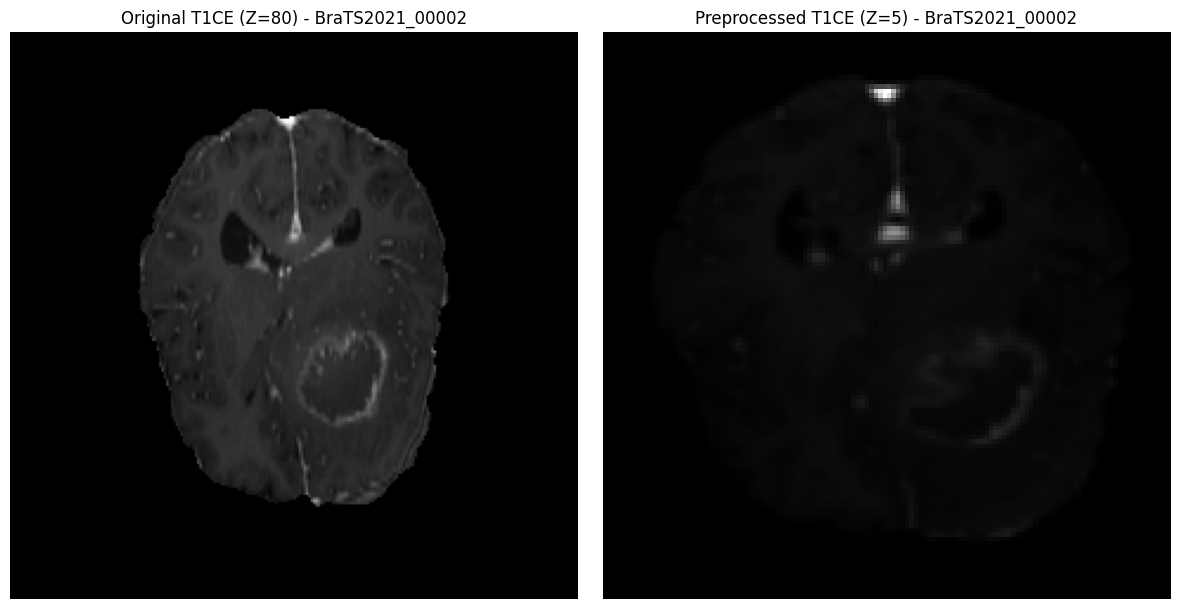

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def compare_preprocessed_vs_original(patient_id, extracted_dir, preprocessed_dir):
    """
    Plots a comparison between an original brain slice (T1CE, Z=80) from BraTS_2021_extracted
    and a preprocessed brain slice (T1CE, Z=5) from BraTS_2021_preprocessed_6.

    Args:
        patient_id (str): The patient identifier.
        extracted_dir (str): Path to the BraTS_2021_extracted dataset.
        preprocessed_dir (str): Path to the BraTS_2021_preprocessed_6 dataset.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Load original T1CE image (Z=80) from BraTS_2021_extracted
    extracted_path = os.path.join(extracted_dir, patient_id, f"{patient_id}_t1ce.nii.gz")
    if not os.path.isfile(extracted_path):
        raise FileNotFoundError(f"Original T1CE file not found: {extracted_path}")

    img_extracted = nib.load(extracted_path).get_fdata()
    slice_original = img_extracted[:, :, 80].T  # Transpose for correct orientation

    # Search for patient in BraTS2021_train
    train_dir = os.path.join(preprocessed_dir, "BraTS2021_train")
    patient_dirs = [p for p in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, p))]
    if patient_id not in patient_dirs:
        raise FileNotFoundError(f"Patient {patient_id} not found in BraTS2021_train.")

    preprocessed_path = os.path.join(train_dir, patient_id, f"{patient_id}_t1ce.nii.gz")
    if not os.path.isfile(preprocessed_path):
        raise FileNotFoundError(f"Preprocessed T1CE file not found: {preprocessed_path}")

    img_preprocessed = nib.load(preprocessed_path).get_fdata()
    slice_preprocessed = img_preprocessed[:, :, 5].T  # Transpose for correct orientation

    # Plot original
    axes[0].imshow(slice_original, cmap='gray', origin='lower')
    axes[0].set_title(f"Original T1CE (Z=80) - {patient_id}")
    axes[0].axis("off")

    # Plot preprocessed
    axes[1].imshow(slice_preprocessed, cmap='gray', origin='lower')
    axes[1].set_title(f"Preprocessed T1CE (Z=5) - {patient_id}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


patient_id = "BraTS2021_00002"
extracted_dir = "/Volumes/Untitled/BraTS2021_extracted"
preprocessed_dir = "/Volumes/Untitled/BraTS2021_preprocessed_6"

compare_preprocessed_vs_original(patient_id, extracted_dir, preprocessed_dir)

##### <span style="color: green;">**Comment:**</span>

For us humans, the tumor appears much more visible in the image on the left. However, with the same number of epochs, the preprocessing on the right doubles the Dice and IoU metric values while also reducing the model's training time.

### **2. Segmentation with a CNN UNet Model**


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import nibabel as nib
import numpy as np
import random
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt



#### **2.a. Dataset preparation**

* Creation of a BraTSDataset class to convert NIfTI volumes into tensors.
* Construction of train_loader, val_loader, and test_loader with a batch size of 16.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, num_patients=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        all_patients = sorted(os.listdir(root_dir))
        if num_patients:
            self.patients = random.sample(all_patients, min(num_patients, len(all_patients)))
        else:
            self.patients = all_patients

        # The new volumes have exactly 9 slices indexed from 0 to 8
        self.num_slices_per_patient = 9
        self.index_mapping = [
            (patient_id, slice_idx)
            for patient_id in self.patients
            for slice_idx in range(self.num_slices_per_patient)  # Ensures slice_idx is in [0-8]
        ]

    def __len__(self):
        return len(self.index_mapping)

    def __getitem__(self, idx):
        patient_id, slice_idx = self.index_mapping[idx]  # slice_idx is guaranteed to be in [0-8]

        patient_path = os.path.join(self.root_dir, patient_id)
        t1ce_path = os.path.join(patient_path, f"{patient_id}_t1ce.nii.gz")
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii.gz")

        t1ce = nib.load(t1ce_path).get_fdata()
        mask = nib.load(seg_path).get_fdata()

        # Strict verification that the volume has exactly 9 slices
        if t1ce.shape[2] != 9 or mask.shape[2] != 9:
            raise ValueError(
                f"[ERROR] {patient_id} - Incorrectly formatted volume: {t1ce.shape}, expected (128, 128, 9)"
            )

        # Directly using slice_idx (guaranteed to be in [0-8])
        image_slice = np.stack([t1ce[:, :, slice_idx]], axis=0)  # (1, 128, 128)
        mask_slice = mask[:, :, slice_idx]  # (128, 128)

        # Remapping mask classes
        mask_slice[mask_slice == 4] = 3

        # Strict verification of mask values
        if mask_slice.min() < 0 or mask_slice.max() >= 4:
            raise ValueError(
                f"[ERROR] {patient_id} - Invalid values in the mask! Min: {mask_slice.min()}, Max: {mask_slice.max()}"
            )

        # Conversion to tensors
        image_tensor = torch.tensor(image_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.int64)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, mask_tensor


In [4]:
# Define dataset paths
base_path = "/content/drive/MyDrive/BraTS2021_preprocessed_6"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "BraTS2021_val")
test_path = os.path.join(base_path, "test")

# Create 400 different train datasets for 400 training epochs,
# randomly selecting patients for each epoch
num_epochs = 400
num_patients_per_epoch = 20
batch_size = 32

train_loaders = {}

for epoch in range(num_epochs):
    train_dataset = BraTSDataset(train_path, num_patients=num_patients_per_epoch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_loaders[f"epoch_{epoch}"] = train_loader


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

By selecting 20 random patients per epoch out of 751, we introduce stochasticity into the training process, which:

* Reduces overfitting by preventing the model from adapting too much to a fixed subset of patients.
* Decreases training time by reducing the number of images processed per epoch.
* Improves generalization by exposing the model to more inter-patient diversity over epochs.
* Acts similarly to mini-batch SGD but at the patient level, facilitating more stable convergence.
* Limits dataset bias impact  by preventing certain patients from being overrepresented.
* Adds a new parameter num_patients_per_epoch, enabling a more fine-tuned optimization approach.

</div>

In [7]:
base_path = "/content/drive/MyDrive/BraTS2021_preprocessed_6"
val_path = os.path.join(base_path, "validation")

# Create validation dataset `val_dataset` with a random selection of patients
val_dataset = BraTSDataset(val_path, num_patients=10)

# Create DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

The val_loader is small --> 10 patients. The only reason is to recude training time. But it would have been better to take a larger one in order to have more stable results per epoch for the validation sample.

</div>

In [58]:
base_path = "/content/drive/MyDrive/BraTS2021_preprocessed_6"
test_path = os.path.join(base_path, "test")

# Create test dataset `test_dataset` with a random selection of patients
test_dataset = BraTSDataset(test_path, num_patients=50)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

The test_loader is composed of 50 patients. We have judged that 50 patients is sufficient to showcase interpretable results with a correct diversity.

</div>

#### **2.b. Model Definition**




![UNet Architecture](The-architecture-of-UNet.png)

**Our UNet architecture:**

* An encoder: 5 levels of feature extraction using DoubleConv (Conv 3×3 + BatchNorm + ReLU + Dropout) and MaxPooling 2×2 to reduce resolution.
* A bottleneck: The deepest layer with 512 channels before upsampling begins.
* A decoder: 4 upsampling steps using bilinear upsampling and feature concatenation from the encoder (skip connections).
* An output layer 🎯: A final 1×1 convolution to generate a segmentation map with n_classes channels.

**Why choosing UNet ?**

* Skip connections to preserve details
* Architecture designed for segmentation (unlike CNN with ResNet or MobileNet backbones)
* Performs well on small datasets
* Flexible and extensible

**UNet drawbacks:**

* More memory-intensive
* Less robust to scale variations
* Slower than MobileNet for real-time segmentation

In [11]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU => Dropout) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_prob=0.5):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, dropout_prob=0.5):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

Few differences compared to a classical UNet:

* Dropout (0.5) added after each ReLU to improve regularization.
* Bilinear upsampling instead of transposed convolution.
* Dynamic padding to handle dimension differences during concatenation.

Why Bilinear upsampling?

* Avoids grid artifacts
* Consumes less memory
* Faster and more stable on small datasets
* Better preserves contours in medical segmentation

</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">To go further :</span>**  

* UNet modifications:
    - Replace bilinear upsampling with transposed convolution (nn.ConvTranspose2d) for learnable upsampling.
    - Modify the Bottleneck Depth: 256 or 1024 channels
    - Add extra encoder-decoder block for deeper feature extraction
    - Use more filters per convolutional layer to capture finer details
    - Replace activation functions: ReLU → LeakyReLU
    - ReLU → LeakyReLU
    - Use Attention Mechanisms: Attention U-Net

* Using UNet++: Dense skip connections for better feature fusion across different levels.
More refined segmentation by gradually improving predictions at different scales.

* Using other architectures:
    - Backbone ResNet
    - DeepLabV3+
    - PSPNet
    - SegFormer (CNN-Transformer hybrid for segmentation)
    - ...

* Using a Pre-trained Model (MS COCO or ImageNet): For instance, fine-tune a UNet variant that was pre-trained on MS COCO for segmentation.

* Using a Transformer-Based Model (ViT, Swin-UNet, etc)


</div>


#### **2.c. Definition of IoU and Dice Metrics**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;">Definition :</span>**  

**Dice Coefficient**  

The **Dice Coefficient** is a similarity metric used to evaluate the overlap between the predicted segmentation and the ground truth. It ranges from **0 (no overlap)** to **1 (perfect overlap)** and is particularly useful for medical image segmentation.

*Formula:*
$$
Dice = \frac{2 \times |A \cap B|}{|A| + |B|}
$$
where:  
- $A$ = set of pixels in the **ground truth mask**  
- $B$ = set of pixels in the **predicted mask**  
- $|A \cap B|$ = number of overlapping pixels between **A** and **B**  

---

**Intersection over Union (IoU)**  

The **Intersection over Union (IoU)**, also called the **Jaccard Index**, measures how well the predicted segmentation overlaps with the ground truth. It is widely used in object detection and segmentation, with values between **0 (no overlap)** and **1 (perfect match).**

*Formula:*
$$
IoU = \frac{|A \cap B|}{|A \cup B|}
$$
where:  
- $A$ = set of pixels in the **ground truth mask**  
- $B$ = set of pixels in the **predicted mask**  
- $|A \cap B|$ = number of overlapping pixels  
- $|A \cup B|$ = total number of pixels in **A** or **B**  

**Difference:** Dice is more sensitive to small objects, while IoU gives a direct measure of overlap proportion.

</div>


In [12]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Computes the Dice Coefficient for each class (excluding the background class).
    Then returns the average Dice score across classes.

    Args:
        y_true (tensor): (B, H, W) -> Ground truth mask
        y_pred (tensor): (B, H, W) -> Predicted mask after argmax

    Returns:
        float: Mean Dice score across all foreground classes.
    """
    dice_scores = []

    for class_id in range(1, 4):  # Excluding the background class (0)
        y_true_f = (y_true == class_id).float().flatten()
        y_pred_f = (y_pred == class_id).float().flatten()
        intersection = (y_true_f * y_pred_f).sum()
        dice = (2.0 * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)
        dice_scores.append(dice.item())

    return sum(dice_scores) / len(dice_scores)  # Mean Dice score across all foreground classes

def iou_coef(y_true, y_pred, smooth=1e-6):
    """
    Computes the Intersection over Union (IoU) for each class (excluding the background class).
    Then returns the average IoU score across classes.

    Args:
        y_true (tensor): (B, H, W) -> Ground truth mask
        y_pred (tensor): (B, H, W) -> Predicted mask after argmax

    Returns:
        float: Mean IoU score across all foreground classes.
    """
    iou_scores = []

    for class_id in range(1, 4):  # Excluding the background class (0)
        y_true_f = (y_true == class_id).float().flatten()
        y_pred_f = (y_pred == class_id).float().flatten()
        intersection = (y_true_f * y_pred_f).sum()
        union = y_true_f.sum() + y_pred_f.sum() - intersection
        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou.item())

    return sum(iou_scores) / len(iou_scores)  # Mean IoU score across all foreground classes


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

The Dice Coefficient and IoU metrics exclude class 0 ("no tumor"), meaning they only evaluate segmentation performance on tumor regions. As a result, their values are highly sensitive to small variations in pixel labels within the tumor, making them particularly useful for assessing fine-grained segmentation accuracy.

</div>

#### **2.c. Definition of the Dice Loss**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;">Definition :</span>**  

**Dice Loss (Soft Dice Loss)**

The **Dice Loss** is a metric-based loss function commonly used for image segmentation tasks. It is derived from the **Dice Coefficient**, which measures the overlap between the predicted segmentation and the ground truth. Unlike standard losses like cross-entropy, Dice Loss directly optimizes for **segmentation accuracy**, especially in imbalanced datasets where tumor pixels are much fewer than background pixels.

This implementation is a **Soft Dice Loss**, meaning it works with **probability values (softmax outputs)** rather than discrete class labels. In contrast, **Hard Dice Loss** is computed using thresholded binary masks (e.g., after argmax selection).

*Formula*
$$
\mathcal{L}_{Dice} = 1 - \frac{2 \sum_{i} p_i t_i + \epsilon}{\sum_{i} p_i + \sum_{i} t_i + \epsilon}
$$

where:
- $ p_i $ = predicted probability for pixel \( i \) (after softmax)
- $ t_i $ = ground truth one-hot encoded label for pixel \( i \)
- $ \sum_{i} $ = sum over all pixels
- $ \epsilon $ = small smoothing term to avoid division by zero

**Why use Soft Dice?** It provides a **differentiable loss** that allows smooth gradient updates, improving optimization for segmentation networks.


</div>


In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5, ignore_background=False):
        super().__init__()
        self.smooth = smooth
        self.ignore_background = ignore_background

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        dice_per_class = []
        # Beginning at 1 if we want to ignore class 0
        start_class = 1 if self.ignore_background else 0
        for c in range(start_class, num_classes):
            p = probs[:, c, ...]
            t = one_hot[:, c, ...]
            intersection = (p * t).sum(dim=(1,2))
            denom = p.sum(dim=(1,2)) + t.sum(dim=(1,2))
            dice_c = (2. * intersection + self.smooth) / (denom + self.smooth)
            dice_per_class.append(dice_c.mean())  # mean on batch

        mean_dice = torch.stack(dice_per_class).mean() if len(dice_per_class) > 0 else 0.0
        return 1.0 - mean_dice

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

Training was performed using a Soft Dice Loss that ignored class 0. However, the results were disappointing. The predicted masks contained almost no class 0 pixels.


</div>

#### **2.d. Model Training**

**Training Configuration Summary:**

- *Model*: UNet  
- *Loss Function*: Dice Loss  

- *Optimizer*: Adam  
- *Learning Rate*: \( 1e-4 \)  
- *Weight Decay (L2 Regularization)*: \( 1e-5 \)

- *Number of Epochs*: 400
- *Number patient per Epoch*: 20  
- *Batch Size*: 16   
- *Device*: GPU Google Colab

- *Validation Loss*: Dice Loss  
- *Segmentation Performance Metrics*:  
  - Dice Coefficient  
  - IoU

**Model weight**: 69.1 Mo


In [14]:

# Initialiser le UNet et la DiceLoss
# ---------------------------
model = UNet(n_channels=1, n_classes=4)
dice_loss_fn = DiceLoss(smooth=1e-5, ignore_background=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Vérifier disponibilité GPU
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used for training.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Training will be on CPU.")
    device = torch.device("cpu")

#########################
## Model Training Loop ##
#########################

model = model.to(device)  # Ensure the model is on GPU

list_avg_train_loss = []
list_avg_val_loss = []
list_avg_dice = []
list_avg_iou = []

# ---------------------------
# Training Loop
# ---------------------------
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    train_loader = train_loaders[f"epoch_{epoch}"]

    for X, y in train_loader:
        X, y = X.to(device).float(), y.to(device)
        optimizer.zero_grad()
        output_masks = model(X)

        # Compute Dice Loss
        loss = dice_loss_fn(output_masks, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    list_avg_train_loss.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    dice_scores = []
    iou_scores = []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device).float(), y_val.to(device)
            output_val = model(X_val)

            # Compute Validation Loss
            loss_val = dice_loss_fn(output_val, y_val)
            val_loss += loss_val.item()

            # Get Predictions
            pred_val = torch.argmax(output_val, dim=1)

            # Compute Dice & IoU scores
            d = dice_coef(y_val, pred_val)
            i = iou_coef(y_val, pred_val)
            dice_scores.append(d)
            iou_scores.append(i)

    avg_val_loss = val_loss / len(val_loader)
    list_avg_val_loss.append(avg_val_loss)

    avg_dice = sum(dice_scores) / len(dice_scores)
    list_avg_dice.append(avg_dice)

    avg_iou = sum(iou_scores) / len(iou_scores)
    list_avg_iou.append(avg_iou)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" -> Train Loss: {avg_train_loss:.4f}")
    print(f" -> Val   Loss: {avg_val_loss:.4f}")
    print(f" -> Dice(val): {avg_dice:.4f}")
    print(f" -> IoU(val):  {avg_iou:.4f}")



CUDA is available. GPU will be used for training.
Epoch 1/400
 -> Train Loss: 0.8626
 -> Val   Loss: 0.8697
 -> Dice(val): 0.0227
 -> IoU(val):  0.0118
Epoch 2/400
 -> Train Loss: 0.8539
 -> Val   Loss: 0.8607
 -> Dice(val): 0.0000
 -> IoU(val):  0.0000
Epoch 3/400
 -> Train Loss: 0.8386
 -> Val   Loss: 0.8550
 -> Dice(val): 0.0007
 -> IoU(val):  0.0003
Epoch 4/400
 -> Train Loss: 0.8272
 -> Val   Loss: 0.8520
 -> Dice(val): 0.0391
 -> IoU(val):  0.0209
Epoch 5/400
 -> Train Loss: 0.8184
 -> Val   Loss: 0.8566
 -> Dice(val): 0.0268
 -> IoU(val):  0.0140
Epoch 6/400
 -> Train Loss: 0.8020
 -> Val   Loss: 0.8591
 -> Dice(val): 0.0249
 -> IoU(val):  0.0130
Epoch 7/400
 -> Train Loss: 0.7818
 -> Val   Loss: 0.8616
 -> Dice(val): 0.0378
 -> IoU(val):  0.0198
Epoch 8/400
 -> Train Loss: 0.7885
 -> Val   Loss: 0.8625
 -> Dice(val): 0.1147
 -> IoU(val):  0.0688
Epoch 9/400
 -> Train Loss: 0.7740
 -> Val   Loss: 0.8680
 -> Dice(val): 0.1674
 -> IoU(val):  0.1053
Epoch 10/400
 -> Train Loss: 0.7

In [15]:
torch.save(model.state_dict(), "/content/drive/MyDrive/modeles/model_unet.pth")
print("Model UNet saved.")


Model UNet saved.


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

The **core of this study** is not about optimizing a CNN model for segmentation but rather **calibrating it**. However, some adjustments were made:

**Hyperparameters Tested**

- *Learning rates tested*: $ 1e-5 $ and $ 1e-4 $  
- *Loss functions tested*: Cross-Entropy Loss and Dice Loss  
- *Number of epochs tested*: 50, 100, 200, and 400  
- *Patients per epoch tested*: 10, 20, 50  
- *Batch size tested*: 4, 8, 16  



</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">**Potential improvements for further better segmentations** :</span>**  

- Finer preprocessing method such as Sobel filters.
- Data augmentation: Random rotation, etc..
- Test more learning rates  
- Test more "num_epoch" and "patient_per_epoch"
- Try other loss functions suitable for segmentation, such as:  
  - weighted Cross-Entropy  
  - Focal Loss
  - Boundary Loss   

- Adjust L2 regularization ("weight decay")  
- Modify dropout probability (currently set to 0.5)   
- Try different optimizers instead of Adam, such as:  
  - SGD (with momentum)
  - AdamW  
  - RMSprop  
  - Nadam  
  - Lookahead Optimizer  
- Switching to Instance Normalization rather than Batch Normalization


</div>


#### **2.e. Learning Curves**

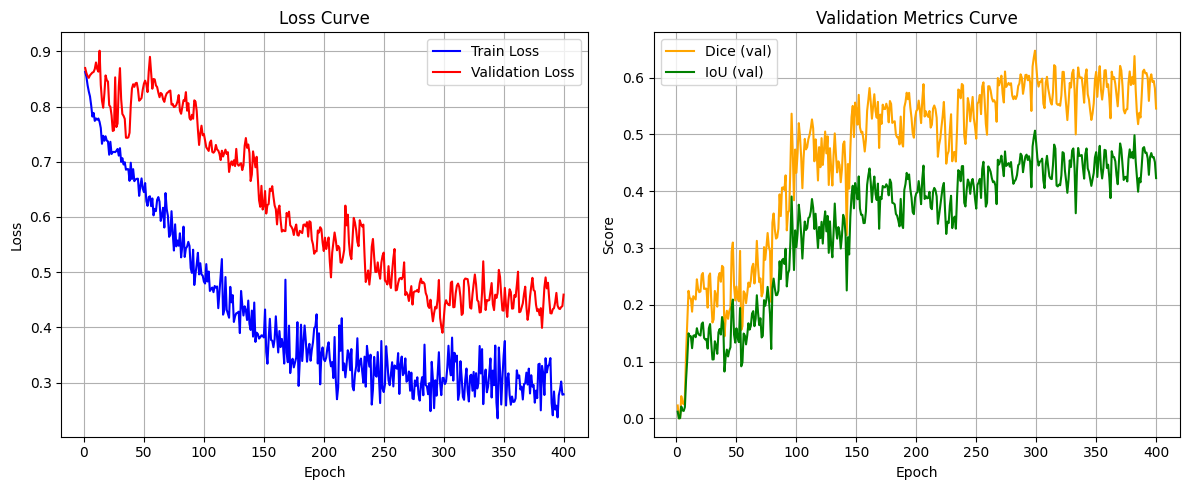

In [16]:
num_epochs = len(list_avg_train_loss)
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# ------------------
# Subplot 1 (left): Train & Validation Loss
# ------------------
axes[0].plot(epochs, list_avg_train_loss, label='Train Loss', color='blue')
axes[0].plot(epochs, list_avg_val_loss, label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True)

# ------------------
# Subplot 2 (right): Dice & IoU (Validation)
# ------------------
axes[1].plot(epochs, list_avg_dice, label='Dice (val)', color='orange')
axes[1].plot(epochs, list_avg_iou, label='IoU (val)', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()



<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

- **Observation 1:** High Variability / Instability Across All Metrics
    
    - Reason 1: The training dataset is small (751 patients) and contains high inter-patient variability in brain slices. When the model learns from 20 new patients per epoch, the model parameters fluctuate significantly, leading to unstable metrics.

    - Reason 2: The validation dataset is extremely small (only 10 patients), making it highly sensitive to parameter changes between epochs. This dataset does not represent the full distribution of all 1251 patients, leading to erratic validation metrics.

    - Reason 3: Hard Dice and IoU metrics are even more unstable than Dice Loss because they are computed using discrete class labels, while Dice Loss works on probabilities. Additionally, Dice and IoU exclude class 0 (background/no tumor), whereas Dice Loss considers all classes, leading to different dynamics.

    - Reason 4: The heterogeneity of MRI scans introduces further instability, making generalization harder.

---

- **Observation 2:** Validation Loss Drops Then plateauise, same for Training Loss  (Overfitting Indicator)

    - Reason 1: The validation Dice and IoU scores drop toward the end of training, confirming that the model is losing generalization capabilities.

    - Reason 2: Lack of regularization (e.g., dropout, weight decay tuning) could be contributing to overfitting.

---

- **Observation 3:** Validation Loss Remains High 

    - Reason 1: The validation dataset may be too small to capture the diversity of tumor appearances, leading to unreliable loss estimates.

    - Reason 2: The current loss function (Dice Loss) may not be sufficient for robust generalization. A hybrid loss like Tversky Loss, Focal Dice Loss, or Boundary Loss could better handle class imbalance and improve generalization.

---

- **Observation 4:** IoU and Dice Validation Metrics Plateau and Become Highly Fluctuating

    - Reason 1: After 100-150 epochs, IoU and Dice (val) stop improving and start fluctuating, indicating the model has reached a limit in its ability to generalize.

    - Reason 2: The small number of patients per epoch (20) introduces high variance, making convergence harder.


</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">**What should be done?** :</span>**  

* Increase validation dataset size (at least 100 patients) for more stable evaluation.

* Increase learning rate to accelerate training.

* Use a learning rate scheduler to prevent excessive training and early stopping.

* Increase num_patients_per_epoch to reduce metric variance between epochs.

* Test alternative loss functions (e.g., Focal Dice Loss, Tversky Loss, Boundary Loss) to better handle segmentation uncertainties.

* Introduce data augmentation to increase dataset diversity and help generalization.

* Experiment with different models:
    * ResUNet, Attention UNet, UNet++ (better feature fusion).
    * Transformers (SwinUNet, TransUNet, SegFormer) for better contextual understanding.

---

And...

... **calibration** ! What is the precise subject of our study. And that is why we are not unhappy of these results because we will have a better understanding of its effects !


</div>


#### **2.f. Results (IoU + Dice, 4 examples with confidence map and predicted masks)**

In [59]:
def evaluate_unet(model, test_loader, device):
    """
    Evaluate the UNet model on the test dataset.

    Args:
        model (torch.nn.Module): The trained UNet model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device (CPU or GPU) for computation.

    Returns:
        tuple: Mean Dice score and Mean IoU score.
    """
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device).float()
            y_test = y_test.to(device)

            logits = model(X_test)
            pred_test = logits.argmax(dim=1)

            dice_val = dice_coef(y_test, pred_test)
            iou_val = iou_coef(y_test, pred_test)
            dice_scores.append(dice_val)
            iou_scores.append(iou_val)

    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)

    print(f"[Test] Dice: {mean_dice:.4f}")
    print(f"[Test] IoU: {mean_iou:.4f}")
    return mean_dice, mean_iou

# 1) Create an instance of the model and move it to the selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=4).to(device)

# 2) Load the saved weights from the model_unet.pth file
checkpoint_path = "/content/drive/MyDrive/modeles/model_unet.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  # Set evaluation mode (disables BatchNorm in training mode, etc.)

print("UNet model successfully loaded!")

# 3) Call the evaluation function
mean_dice, mean_iou = evaluate_unet(model, test_loader, device)


<ipython-input-59-e45d7701a219>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


UNet model successfully loaded!
[Test] Dice: 0.4779
[Test] IoU: 0.3919


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

The results here are not very good. But slightly better on the test_loader than the val_loader. Because of the bigger size of the test_loader (50 patients).

</div>

In [18]:
def find_and_visualize_4_non_bg_slices(model, test_loader, device):
    model.eval()
    found_slices = []

    # Définition des indices que l'on veut extraire
    selected_indices = list(range(0, 200, 40))  # Ex: 0, 30, 60, 90, 120...

    with torch.no_grad():
        for i, (X_test, y_test) in enumerate(test_loader):  # On récupère aussi l'index `i`
            if i not in selected_indices:
                continue  # Passe à l'itération suivante si `i` n'est pas un des indices voulus

            # X_test : (1, 1, H, W),  y_test : (1, H, W)
            X_test = X_test.to(device).float()
            y_test = y_test.to(device)

            # Forward pass unique
            logits = model(X_test)  # (1, n_classes, H, W)
            pred_mask = logits.argmax(dim=1)  # (1, H, W)

            # Vérifie si le masque prédit n'est pas entièrement 0
            if (pred_mask != 0).any():
                t1ce_image = X_test[0, 0].cpu()    # (H, W)
                mask_real  = y_test[0].cpu()       # (H, W)
                mask_pred  = pred_mask[0].cpu()    # (H, W)

                # Carte des probabilités max
                probs = F.softmax(logits, dim=1)[0].cpu()  # (n_classes, H, W)
                found_slices.append((t1ce_image, mask_real, probs, mask_pred, i))

                if len(found_slices) == 4:  # Stop après avoir trouvé 4 coupes valides
                    break

    # Affichage des 4 coupes sélectionnées
    for i, (t1ce, mask_r, probs_map, mask_p, idx) in enumerate(found_slices):
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        fig.suptitle(f"Coupe sélectionnée #{idx} (non-fond)", fontsize=14)

        axes[0, 0].imshow(t1ce.numpy(), cmap='gray')
        axes[0, 0].set_title("IRM T1ce")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(mask_r.numpy(), cmap='jet', vmin=0, vmax=3)
        axes[0, 1].set_title("Masque réel")
        axes[0, 1].axis("off")

        values, _ = probs_map.max(dim=0)
        conf_map = values.cpu().numpy()

        im = axes[1, 0].imshow(conf_map, cmap='viridis')
        axes[1, 0].set_title("Carte de confiance (max prob)")
        axes[1, 0].axis("off")
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)

        axes[1, 1].imshow(mask_p.numpy(), cmap='jet', vmin=0, vmax=3)
        axes[1, 1].set_title("Masque prédit")
        axes[1, 1].axis("off")

        plt.tight_layout()
        plt.show()


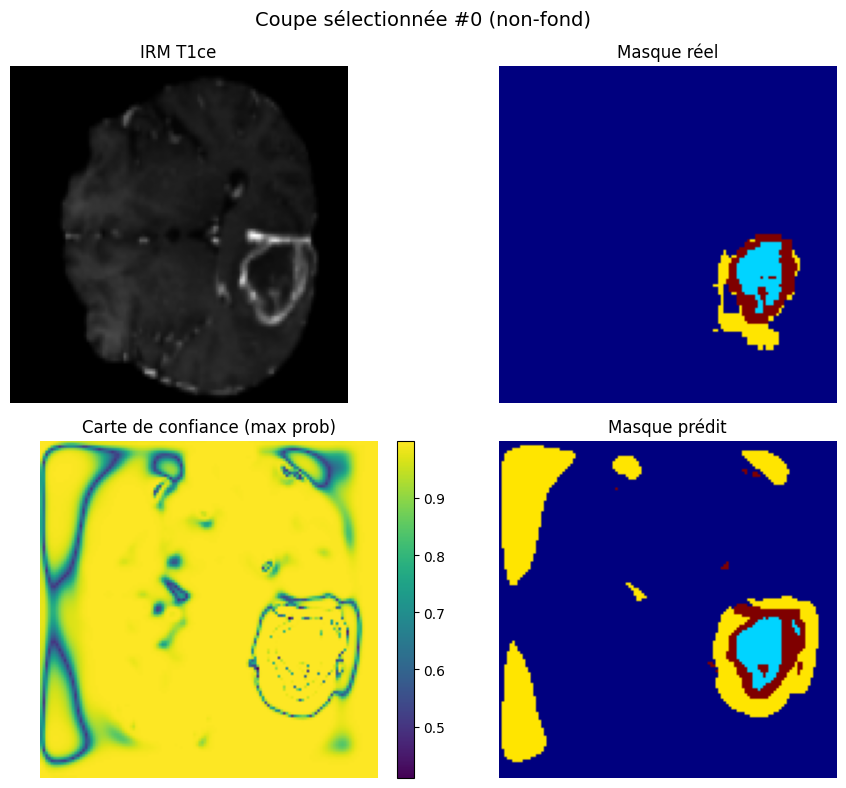

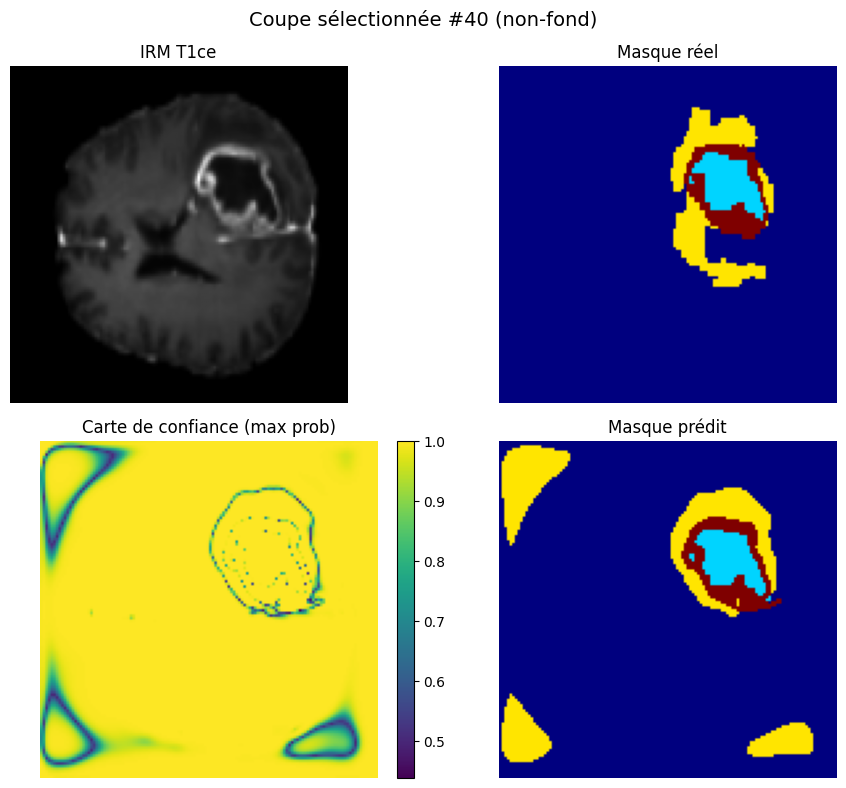

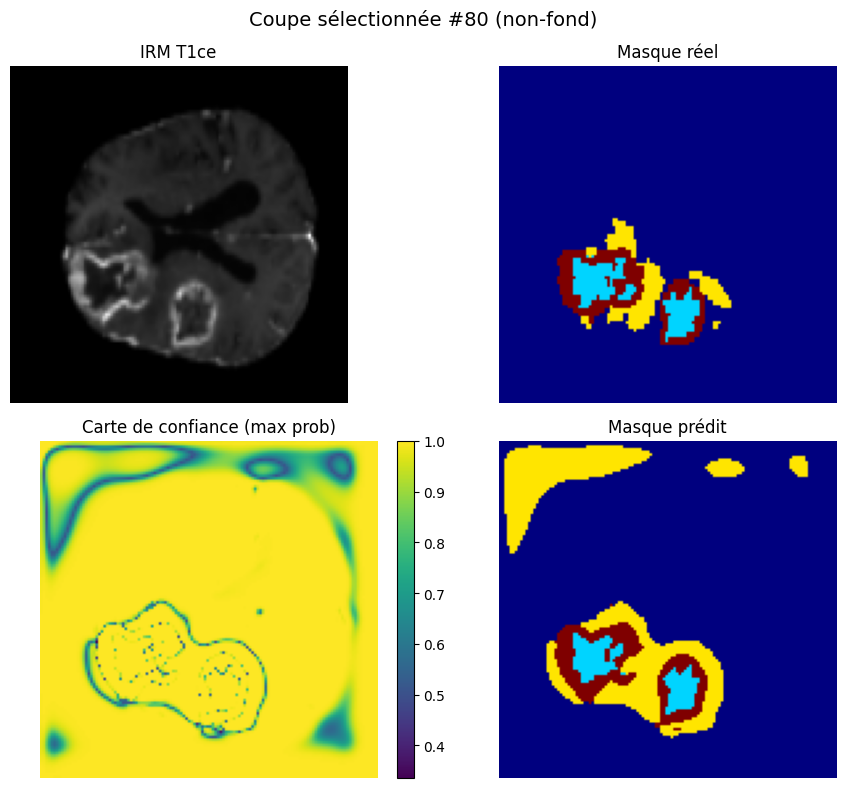

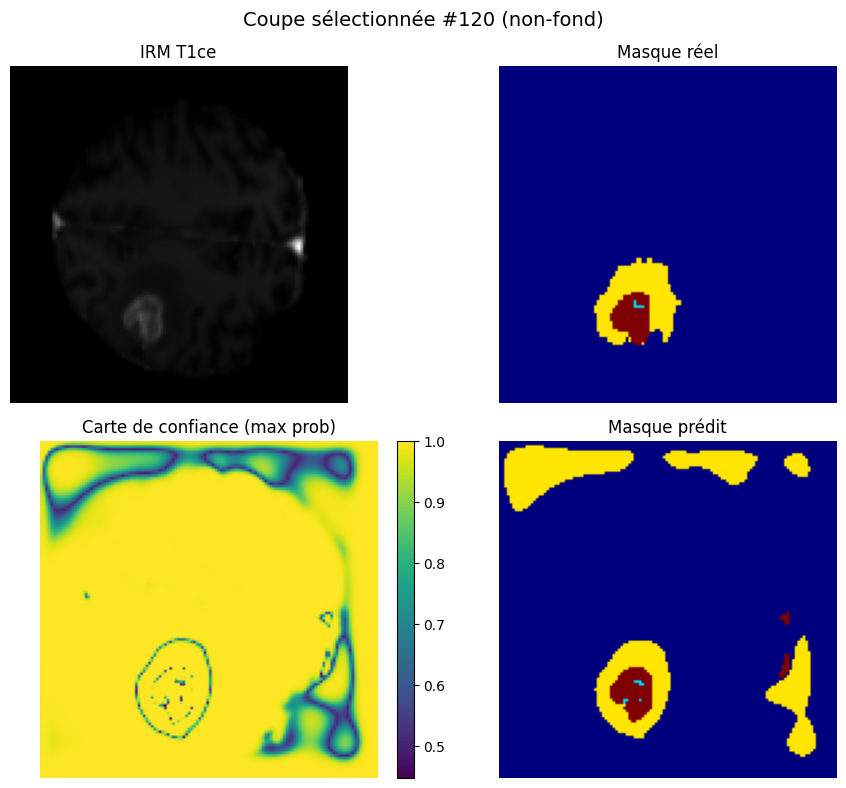

In [60]:
find_and_visualize_4_non_bg_slices(model, test_loader, device)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment :</font>**  

**Initial Training Observations**

A **first training** was conducted with **only 200 epochs**. At that stage, the model was in the **middle of the learning curve**. Visualizing **four test examples**, the model correctly predicted the **black background around the brain** as a non-tumor region (**class = 0**). However, within the tumor region, **the segmentation precision was lower** compared to the model trained for **400 epochs**.

---

**Analysis of the 400-Epoch Model**

This result provides a **key insight**! After training for **400 epochs**, the model **started misclassifying the black background as class 1** (necrotic tumor region). Interestingly, this **misclassified region is the darkest** (lowest pixel intensity) **inside the brain**.

**This suggests that the model is overly relying on pixel intensity (grayscale values) and not enough on the structural organization of the image.** It fails to **understand the inherent structure of MRI scans**—a brain surrounded by a black background, where no tumor should be present.

---

**CNN Limitation: Local vs. Global Structure**

This issue highlights an inherent limitation of **CNN-based segmentation models without attention mechanisms**.  
- CNNs are **highly effective at capturing local features**, which explains why **tumor segmentation appears relatively good**.  
- However, they struggle with **global structures**, leading to poor predictions on contextual elements such as **the background surrounding the brain**.

---

**Hypothesis:** A Local Minimum or Suboptimal Training State?
  
---

**Overconfidence**

We clearly also see that the model is totally **overconfident** on the area where he predicts class 1 on the black background !!

Let's prove it with some **<font color='green'>**calibration methods**</font>**  !!




</div>

### **3. Calibration of the CNN UNet Model**



In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np






#### **3.a. ECE Metric**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;">Definition :</span>**  

The **Expected Calibration Error (ECE)** measures how well a model's predicted probabilities reflect actual correctness. A well-calibrated model should have confidence scores that match the true likelihood of correctness. ECE is computed by partitioning predictions into **bins** based on confidence levels and measuring the gap between **accuracy** and **average confidence** within each bin.

*Formula*:

$$
ECE = \sum_{m=1}^{M} \frac{|B_m|}{N} \left| acc(B_m) - conf(B_m) \right|
$$

Explanation of Terms:

- $ M $ = Number of confidence bins.
- $ B_m $ = Set of predictions falling into bin $ m $.
- $ |B_m| $ = Number of predictions in bin $ m $.
- $ N $ = Total number of predictions.
- $ acc(B_m) $ = Accuracy within bin $ m $.
- $ conf(B_m) $ = Average confidence of predictions in bin $ m $.

A lower ECE value indicates better calibration.


</div>


In [21]:
def expected_calibration_error(probs, labels, n_bins=10):
    """
    Computes the Expected Calibration Error (ECE) for a segmentation model.

    - `probs`: tensor of shape `(batch_size, n_classes, H, W)`, representing softmax probabilities.
    - `labels`: tensor of shape `(batch_size, H, W)`, containing ground truth pixel-wise class labels.
    """
    bins = torch.linspace(0, 1, n_bins + 1)  # Create bins [0, 0.1, ..., 1.0]
    bin_lowers, bin_uppers = bins[:-1], bins[1:]

    ece = 0.0

    # Convert labels into a usable format
    labels_pred = probs.argmax(dim=1)  # (batch_size, H, W) -> Final predicted class labels
    confidences = probs.max(dim=1)[0]  # (batch_size, H, W) -> Confidence associated with the prediction

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Select pixels whose confidence falls within the interval [bin_lower, bin_upper]
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            # Actual accuracy: proportion of correctly classified pixels within the bin
            accuracy_in_bin = (labels_pred[in_bin] == labels[in_bin]).float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()

            # Add the weighted contribution to the ECE
            ece += abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()


#### **3.b. Temperature Scaling**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;">Temperature Scaling calibration :</span>**  

**Temperature Scaling** is a post-hoc calibration technique used to improve the reliability of confidence scores produced by a neural network. The idea is to introduce a **scaling factor (T)** applied to the logits before computing the softmax function:

$$
p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

where:
- $ z_i $ are the raw logits from the model.
- $ T $ is the **temperature** parameter, typically optimized on a validation set.
- **Higher $ T $** makes the softmax outputs more uniform (**reducing overconfidence**).
- **Lower $ T $** sharpens predictions (**making them more confident**).

**Note:**

When performing Temperature Scaling, the optimized parameter $ T $ is **<span style="color: orange;">global</span>**, meaning it is the same for **all pixels** in an image and **all brain slices** in the dataset. This assumes that the miscalibration is consistent across the entire dataset, rather than varying per region or per sample.


</div>


In [22]:
def find_best_temperature(model, val_loader, loss_fn, device):
    """
    Optimizes the temperature T to minimize the calibration error on the validation set.
    """
    model.eval()
    logits_list, labels_list = [], []

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            logits = model(X_val)
            logits_list.append(logits)
            labels_list.append(y_val)

    logits = torch.cat(logits_list).to(device)
    labels = torch.cat(labels_list).to(device)

    # ✅ Initialize temperature T on the correct device
    temperature = torch.tensor(1.0, requires_grad=True, device=device)

    # Optimize T by minimizing the CrossEntropy loss
    optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=50)

    def closure():
        optimizer.zero_grad()
        scaled_logits = logits / temperature
        loss = loss_fn(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(closure)

    return temperature.detach().cpu().item()


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Explanation of Temperature Scaling Implementation :</font>**  

 **Step 1**: Collecting Logits and Labels  
- The function first gathers all **logits** (raw model outputs) and **ground-truth labels** from the validation set.

 **Step 2**: Initializing Temperature Parameter  
- A **learnable parameter** $ T $ is initialized at **1.0** and placed on the correct device.

 **Step 3**: Optimizing $ T $ Using LBFGS  
- The **LBFGS optimizer**, a second-order optimization method, is used to find the best $ T $ that minimizes the **cross-entropy loss**.

 **Step 4**: Scaling Logits and Computing Loss  
- During optimization, the logits are divided by $ T $ before computing softmax probabilities.
- The loss is then computed against the true labels.

 **Step 5**: Returning the Optimized Temperature  
- Once the optimization **converges**, the final temperature value is returned.
- This ensures that the confidence scores are well-calibrated without modifying the trained model weights.

---

**Why Use Cross-Entropy as the Loss Function?**

The **cross-entropy loss** is used because it directly measures the misalignment between predicted probabilities and true labels. Since calibration aims to adjust probability confidence without changing class predictions, minimizing cross-entropy ensures that the softmax probabilities match the expected distribution.



</div>

In [23]:
model = UNet(n_channels=1, n_classes=4)
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint_path = "/content/drive/MyDrive/modeles/model_unet.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print("Model UNet loaded!")

Model UNet loaded!


<ipython-input-23-aaf2a67d16c6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [61]:
# Calibration after training
optimal_temperature = find_best_temperature(model, test_loader, loss_fn, device)
print(f" Best temperature found : {optimal_temperature:.4f}")



 Best temperature found : 1.2272


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

We obtain a calibration temperature of 1.2794, indicating that the model was **overconfident** in its predictions. This result aligns with the confidence maps visualized in Section 2, where the black background was predicted as class 1 with excessively high confidence, even though it should have been classified as class 0 ("no tumor").

</div>

In [62]:
# Before calibration without TS
model.eval()
with torch.no_grad():
    logits_list, labels_list = [], []
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        logits = model(X_test)
        logits_list.append(logits.cpu())
        labels_list.append(y_test.cpu())

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)
    probs_before = torch.softmax(logits, dim=1)  # Probabilities before calibration
    ece_before = expected_calibration_error(probs_before, labels)
    print(f"❌ ECE before calibration : {ece_before:.4f}")


# With TS
with torch.no_grad():
    scaled_logits = logits / optimal_temperature
    probs_after = torch.softmax(scaled_logits, dim=1)  # Probabilities with TS calibration
    ece_after = expected_calibration_error(probs_after, labels)
    print(f"✅ ECE with TS clalibration : {ece_after:.4f}")


❌ ECE before calibration : 0.1029
✅ ECE with TS clalibration : 0.0914


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

The TS calibration is a **<font color='green'>slight success</font>**, but we can do better !

</div>

In [56]:

def find_and_visualize_4_conf_maps_TS(model, test_loader, device, temperature):
    """
    1. Iterates over test_loader (batch_size=1), taking a sample every 30 indices.
    2. Selects 4 slices where the raw prediction (argmax without TS) is not entirely class 0.
    3. Displays, for each selected slice, 5 subplots side by side:
       - T1ce MRI (left)
       - Ground Truth Mask (middle-left)
       - Predicted Mask (before Temperature Scaling) (middle)
       - Confidence Map (before Temperature Scaling) (middle-right)
       - Confidence Map (after Temperature Scaling) (right)
    4. The slice index is displayed for reference.
    """
    model.eval()
    found_slices = []

    with torch.no_grad():
        for idx, (X_test, y_test) in enumerate(test_loader):
            # Process only indices that are multiples of 30
            if idx % 30 != 0:
                continue

            # X_test shape: (1, 1, H, W)
            # y_test shape: (1, H, W)
            X_test = X_test.to(device).float()
            y_test = y_test.to(device)

            # 1) Compute raw logits
            logits = model(X_test)  # (1, n_classes, H, W)

            # 2) Raw prediction (without TS)
            pred_mask = logits.argmax(dim=1)  # (1, H, W)

            # Ensure that the predicted mask is not entirely class 0
            if (pred_mask != 0).any():
                # Prepare data for visualization

                # - T1ce MRI
                t1ce_image = X_test[0, 0].cpu()  # shape: (H, W)

                # - Ground Truth Mask
                ground_truth_mask = y_test[0].cpu()  # shape: (H, W)

                # - Predicted mask (without TS)
                pred_mask_cpu = pred_mask[0].cpu()  # shape: (H, W)

                # - Confidence map (without TS)
                probs_noTS = F.softmax(logits, dim=1)  # (1, n_classes, H, W)
                values_noTS, _ = probs_noTS[0].max(dim=0)  # (H, W)
                conf_noTS_map = values_noTS.cpu()

                # - Confidence map (with TS)
                scaled_logits = logits / temperature
                probs_TS = F.softmax(scaled_logits, dim=1)
                values_TS, _ = probs_TS[0].max(dim=0)
                conf_TS_map = values_TS.cpu()

                found_slices.append(
                    (t1ce_image, ground_truth_mask, pred_mask_cpu, conf_noTS_map, conf_TS_map, idx)
                )

                if len(found_slices) == 4:
                    break

    # Display the 4 selected slices (5 subplots each)
    for (t1ce, gt_mask, pred_mask, conf_noTS, conf_TS, idx) in found_slices:
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        fig.suptitle(f"Slice index #{idx} (non-background prediction)", fontsize=14)

        # Subplot 1: T1ce MRI
        axes[0].imshow(t1ce.numpy(), cmap='gray')
        axes[0].set_title("T1ce MRI")
        axes[0].axis("off")

        # Subplot 2: Ground Truth Mask
        axes[1].imshow(gt_mask.numpy(), cmap='jet', vmin=0, vmax=3)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        # Subplot 3: Predicted Mask (before TS)
        axes[2].imshow(pred_mask.numpy(), cmap='jet', vmin=0, vmax=3)
        axes[2].set_title("Predicted Mask (Before TS)")
        axes[2].axis("off")

        # Subplot 4: Confidence Map (before TS)
        im1 = axes[3].imshow(conf_noTS.numpy(), cmap='viridis', vmin=0.5, vmax=1)
        axes[3].set_title("Confidence Map (Before TS)")
        axes[3].axis("off")
        plt.colorbar(im1, ax=axes[3], fraction=0.046, pad=0.04)

        # Subplot 5: Confidence Map (After TS)
        im2 = axes[4].imshow(conf_TS.numpy(), cmap='viridis', vmin=0.5, vmax=1)
        axes[4].set_title(f"Confidence Map (After TS, T={round(temperature,3)})")
        axes[4].axis("off")
        plt.colorbar(im2, ax=axes[4], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()


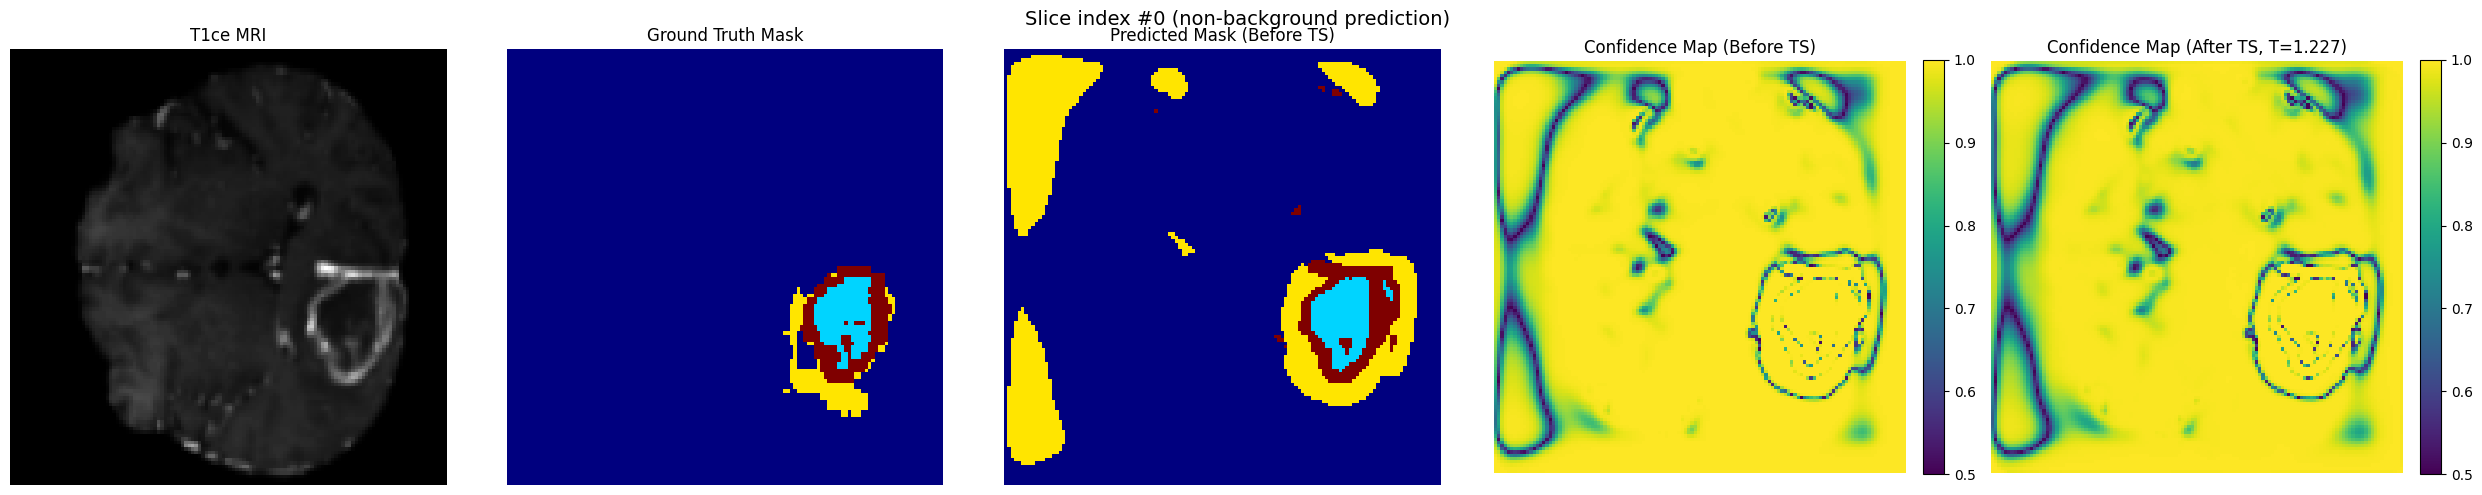

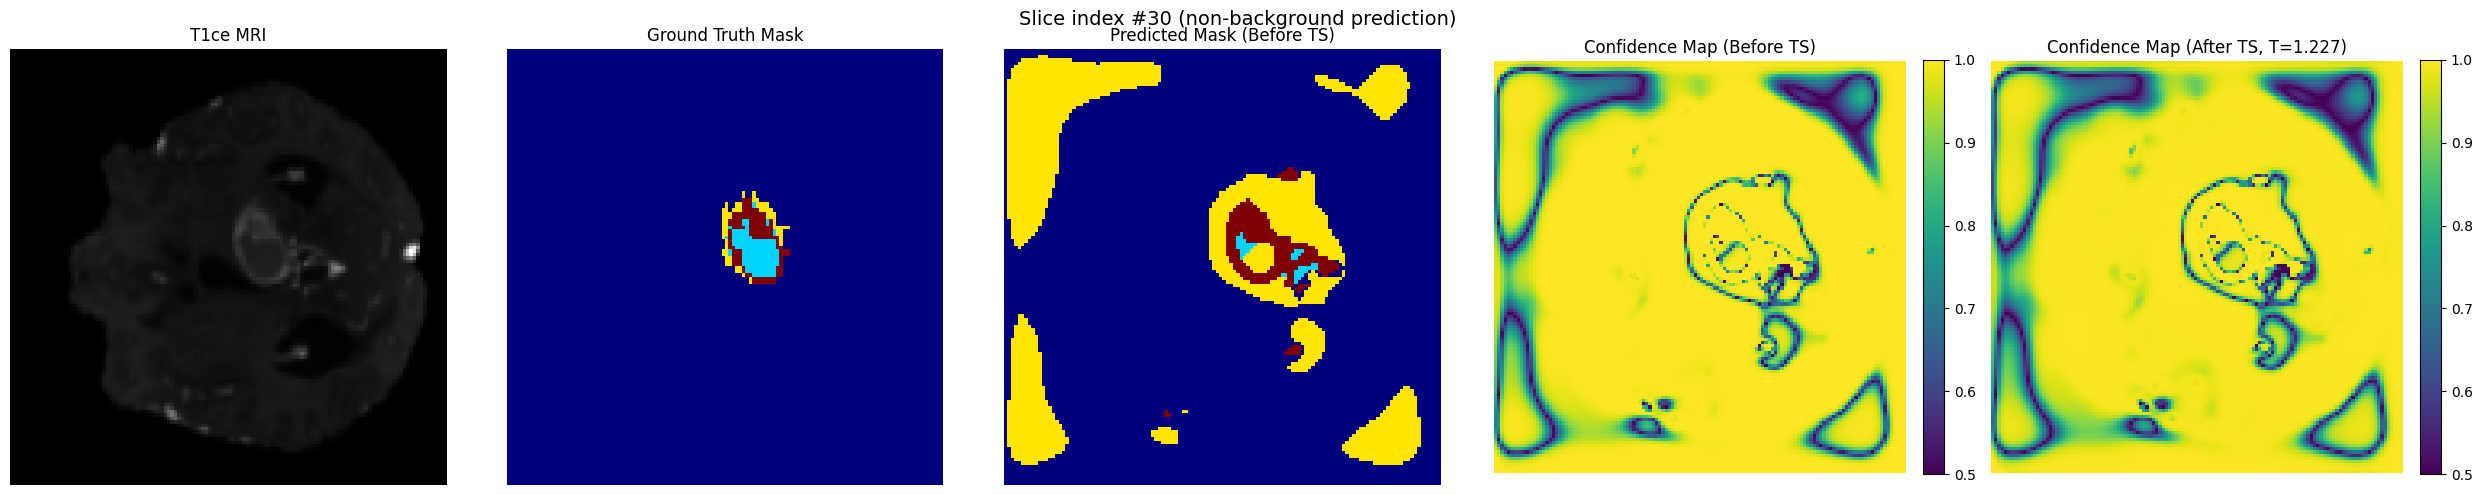

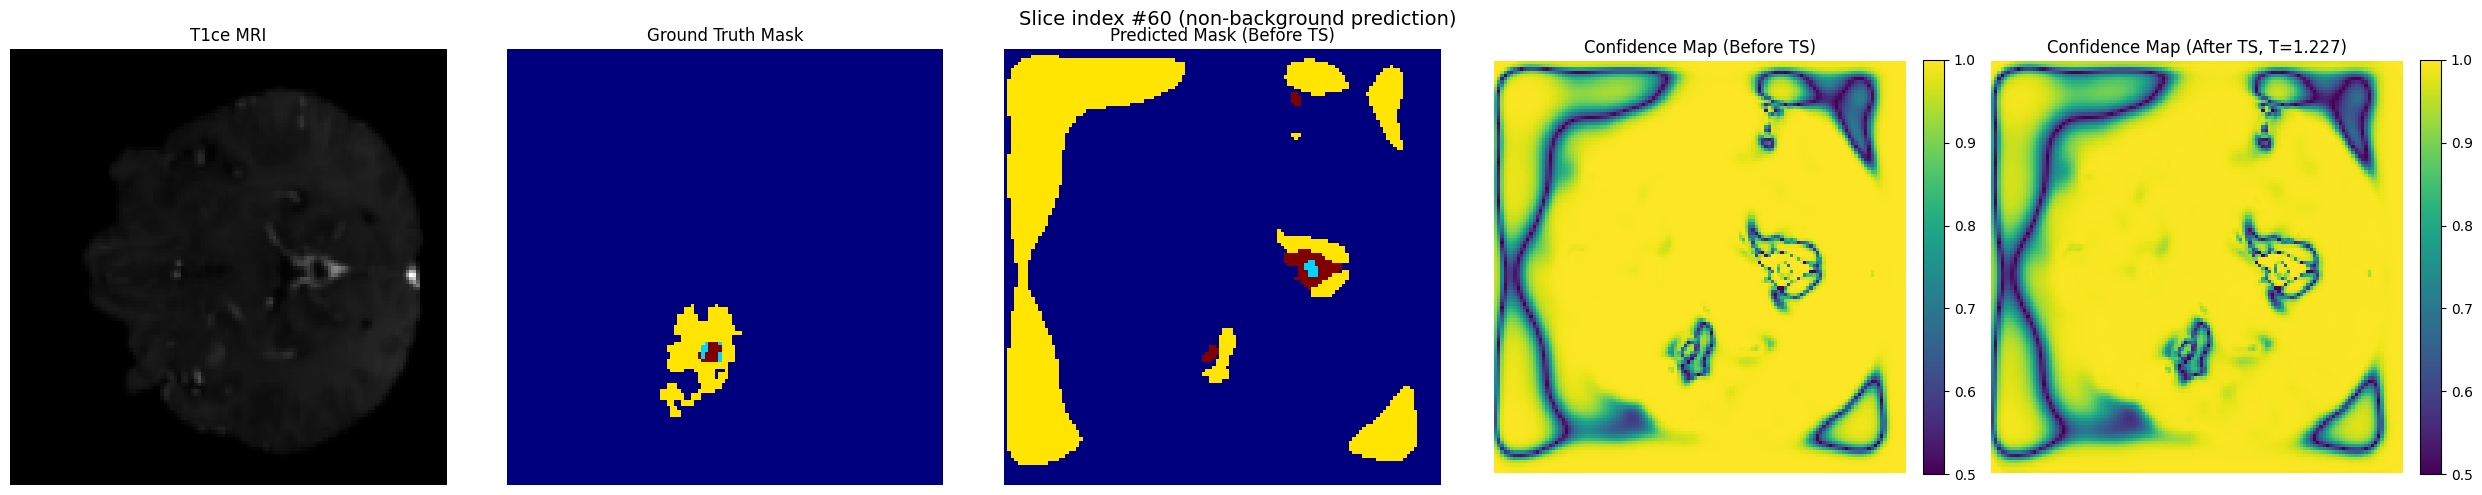

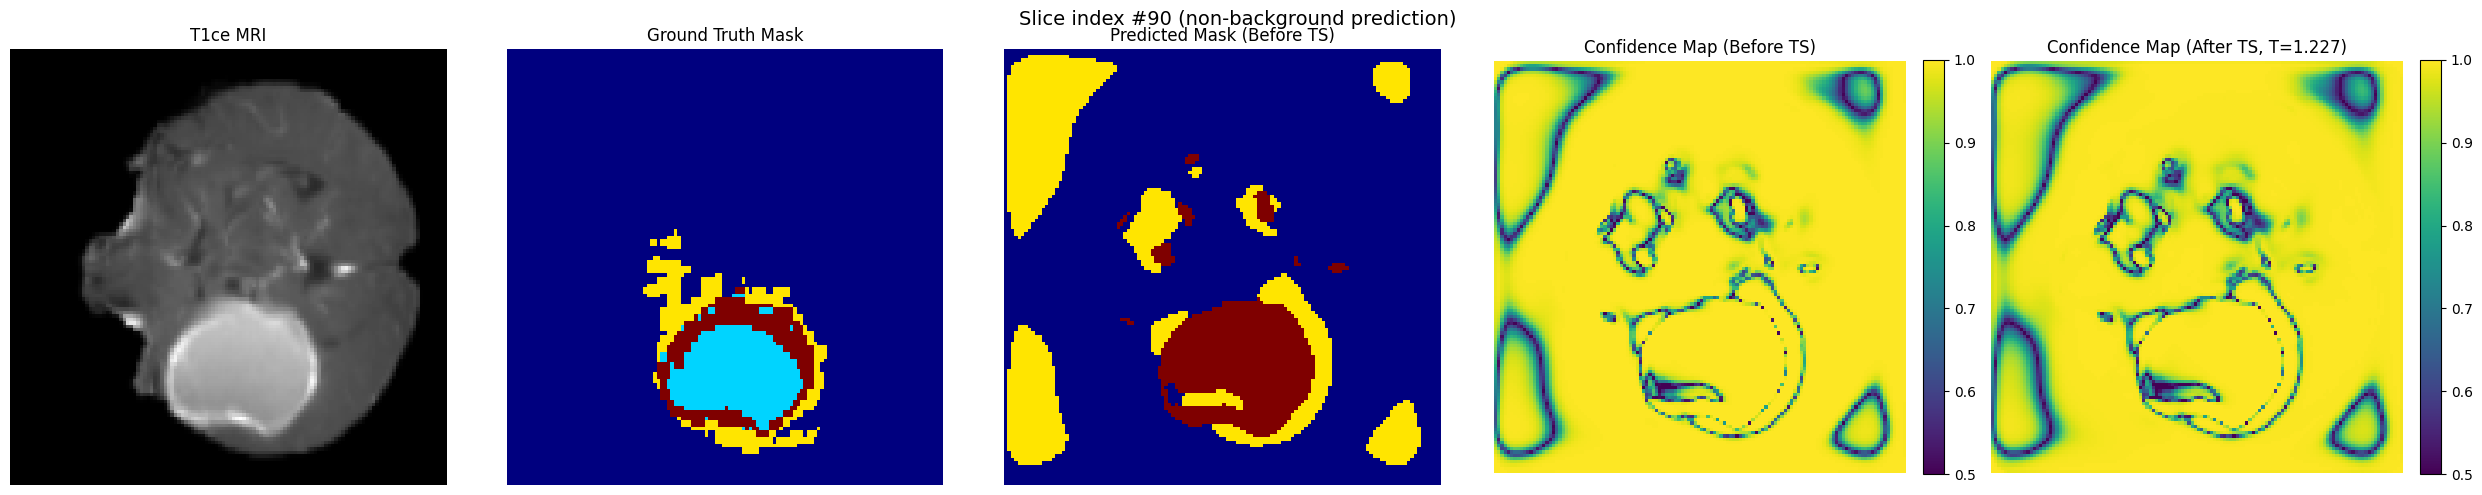

In [64]:
find_and_visualize_4_conf_maps_TS(
    model=model,
    test_loader=test_loader,
    device=device,
    temperature=optimal_temperature
)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

As a reminder, the TS calibration is applying only one **<font color='green'>global</font>** scalar "optimal temperature" on the whole dataset. As T > 1, what we see is just a slight reduction of the confidence in our confidence maps.

</div>

#### **3.c. Adaptive Temperature Scaling**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;"> ATS Definition :</span>**  

**Adaptive Temperature Scaling (ATS)** is an advanced calibration technique that extends **Temperature Scaling** by allowing the temperature parameter **T** to vary across different regions of the image. Instead of a single global temperature, ATS predicts a **temperature map** that is applied **pixel-wise** to the logits before computing the softmax function:

$$
p_i = \frac{\exp(z_i / T_i)}{\sum_j \exp(z_j / T_i)}
$$

where:
- $ z_i $ are the raw logits from the model.
- $ T_i $ is the **temperature** at each pixel, learned through a separate network (temperature head).
- **Higher $ T_i $** flattens the probability distribution (**reducing overconfidence** locally).
- **Lower $ T_i $** sharpens predictions (**making them more confident** locally).

 **Key Differences from Standard Temperature Scaling:**
- **Pixel-wise Calibration:** Each pixel has its own temperature, rather than a single global $T$.
- **Slice-specific Calibration:** Each brain slice gets a unique temperature map, adapting dynamically to different MRI images.
- **More Flexibility:** This method accounts for spatial variations in uncertainty, ensuring that regions with higher uncertainty are properly calibrated.

 **Note:** Applying ATS does not **change the predicted mask (discrete labels).**  
It only adjusts the confidence scores (probabilities) associated with each prediction.


</div>


##### **3.c.1. Model UNetWithATS implementation and training**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;"> Implementing ATS for U-Net</span>**  

In this approach, we keep the **pre-trained U-Net weights fixed** and introduce a new **temperature head** to compute pixel-wise calibration maps **without modifying the original model's predictions**.

**1/ Keeping the Pre-Trained U-Net and Adding a Temperature Head**

- Instead of retraining the U-Net, we **freeze its weights** and use it **only for feature extraction** and raw **logit computation**.
- A **new lightweight head**, called the **temperature head**, is added on top of the U-Net’s logits.
- This head consists of a **$ 3 \times 3 $ convolution** followed by a **Sigmoid activation**, which ensures that the output values stay within **(0,1)**.
- The temperature values are then **exponentiated** to guarantee **strict positivity**:  
  $$ T_i = \exp(\sigma(W_T * logits)) $$  
  where $ W_T $ are the learnable parameters of the temperature head.

**2/ Computing Scaled Logits Without Changing Predictions**

- The temperature head predicts a **pixel-wise temperature map** $ T $ of shape **$ (batch, 1, H, W) $**.
- This temperature map is used only to **rescale** the logits before applying softmax:
  $$ logits^{scaled}_{i} = \frac{logits_i}{T_i} $$  
  - **Important:** This process **does not modify the predicted labels** (i.e., the class with the highest probability remains unchanged).
  - It **only adjusts the confidence scores**, making them more calibrated.

**3/ Training the Temperature Head (Not the U-Net)**

- Since the U-Net is **frozen**, we **only optimize the temperature head**.
- The training objective is to minimize the **Cross-Entropy Loss**, ensuring that the new scaled logits remain well-calibrated:
  $$ \mathcal{L}_{CE} = - \sum y_i \log(\hat{p}_i) $$  
  - Cross-entropy is used because it directly penalizes incorrect class probabilities and is standard for classification and segmentation.
  - By optimizing this loss, the model learns to correct **overconfident or underconfident** predictions.

**4/ Regularizing the Temperature Map**
- A **regularization term** is added to encourage temperature values close to **1.0**, preventing extreme rescaling:
  $$ \mathcal{L} = \mathcal{L}_{CE} + \lambda \cdot \mathbb{E}[T] $$
  - $ \mathbb{E}[T] $ is the **average temperature** across all pixels.
  - $ \lambda $ is a small weight to prevent over-adjustment.


This approach provides **a finer calibration per pixel**, allowing **more reliable uncertainty estimation** without retraining the segmentation model.


</div>

In [28]:
class UNetWithATS(nn.Module):
    """
    U-Net with Adaptive Temperature Scaling (ATS).

    This model extends a standard U-Net by adding a learnable temperature map.
    Instead of using a single global temperature, ATS predicts a temperature map
    for each pixel, allowing for spatially varying confidence calibration.
    """

    def __init__(self, n_channels, n_classes):
        super(UNetWithATS, self).__init__()
        # Using the existing U-Net model
        self.unet = UNet(n_channels, n_classes)

        # Calibration head: Predicts a temperature map from the logits (of shape n_classes).
        # This outputs a single-channel temperature map of size (batch, 1, H, W).
        self.temperature_head = nn.Sequential(
            nn.Conv2d(n_classes, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Ensures output is between 0 and 1, then exponentiated to enforce T > 0.
        )

    def forward(self, x):
        """
        Forward pass of the U-Net with Adaptive Temperature Scaling.

        Args:
            x (Tensor): Input image of shape (batch, n_channels, H, W).

        Returns:
            scaled_logits (Tensor): Logits after applying the learned temperature scaling.
            temp_map (Tensor): The learned pixel-wise temperature map.
        """
        # Obtain raw logits from the U-Net
        logits = self.unet(x)  # Shape: (batch, n_classes, H, W)

        # Predict the temperature map from logits
        temp_map = self.temperature_head(logits)  # Shape: (batch, 1, H, W)
        temp_map = torch.exp(temp_map)  # Transformation to ensure T > 0

        # Apply pixel-wise temperature scaling: each pixel gets its own temperature adjustment
        scaled_logits = logits / temp_map

        return scaled_logits, temp_map


In [78]:
# Instantiate the U-Net with Adaptive Temperature Scaling (ATS)
model_ats = UNetWithATS(n_channels=1, n_classes=4).to(device)

# Load the pre-trained U-Net weights into the model
model_ats.unet.load_state_dict(
    torch.load("/content/drive/MyDrive/modeles/model_unet.pth", map_location=torch.device("cpu"))
)

# Lists to store training and validation loss for ATS
list_avg_train_loss_ats = []
list_avg_val_loss_ats = []

# Freeze all parameters of the U-Net to only train the temperature head
for param in model_ats.unet.parameters():
    param.requires_grad = False

# Optimizer for training only the temperature head
optimizer = torch.optim.Adam(model_ats.temperature_head.parameters(), lr=1e-4, weight_decay=1e-5)

# Cross-Entropy loss function
ce_loss_fn = nn.CrossEntropyLoss()

# Number of epochs for training the temperature scaling
num_epochs = 400

for epoch in range(num_epochs):
    model_ats.train()
    train_loss = 0.0

    # Get the corresponding train loader for the current epoch
    train_loader = train_loaders[f"epoch_{epoch}"]

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Recalibrated logits using ATS
        scaled_logits, temp_map = model_ats(X)

        # Compute Cross-Entropy loss on scaled logits
        loss_ce = ce_loss_fn(scaled_logits, y)

        # Regularization term to stabilize temperature values
        loss_reg = torch.mean(temp_map)  # Encourages T to remain close to 1
        loss = loss_ce + 0.01 * loss_reg

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    list_avg_train_loss_ats.append(avg_train_loss)

    # Validation phase
    model_ats.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            scaled_logits_val, temp_map_val = model_ats(X_val)

            # Compute Cross-Entropy loss on validation set
            loss_val_ce = ce_loss_fn(scaled_logits_val, y_val)
            val_loss += loss_val_ce.item()

    # Compute average validation loss
    avg_val_loss = val_loss / len(val_loader)
    list_avg_val_loss_ats.append(avg_val_loss)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs} | Train CE: {avg_train_loss:.4f} | Val CE: {avg_val_loss:.4f}")


<ipython-input-78-0e1643df493e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/content/drive/MyDrive/modeles/model_unet.pth", map_location=torch.device("cpu")

Epoch 1/400 | Train CE: 0.1556 | Val CE: 0.3727
Epoch 2/400 | Train CE: 0.1595 | Val CE: 0.4453
Epoch 3/400 | Train CE: 0.1695 | Val CE: 0.3711
Epoch 4/400 | Train CE: 0.1422 | Val CE: 0.3617
Epoch 5/400 | Train CE: 0.1689 | Val CE: 0.3963
Epoch 6/400 | Train CE: 0.1468 | Val CE: 0.4454
Epoch 7/400 | Train CE: 0.1656 | Val CE: 0.4208
Epoch 8/400 | Train CE: 0.1899 | Val CE: 0.4814
Epoch 9/400 | Train CE: 0.1685 | Val CE: 0.4174
Epoch 10/400 | Train CE: 0.1476 | Val CE: 0.4024
Epoch 11/400 | Train CE: 0.1895 | Val CE: 0.4492
Epoch 12/400 | Train CE: 0.1711 | Val CE: 0.4474
Epoch 13/400 | Train CE: 0.1460 | Val CE: 0.5161
Epoch 14/400 | Train CE: 0.1722 | Val CE: 0.4437
Epoch 15/400 | Train CE: 0.1715 | Val CE: 0.3639
Epoch 16/400 | Train CE: 0.1478 | Val CE: 0.3861
Epoch 17/400 | Train CE: 0.1905 | Val CE: 0.4249
Epoch 18/400 | Train CE: 0.1560 | Val CE: 0.3967
Epoch 19/400 | Train CE: 0.1253 | Val CE: 0.3939
Epoch 20/400 | Train CE: 0.1766 | Val CE: 0.3839
Epoch 21/400 | Train CE: 0.14

In [79]:
torch.save(model_ats.state_dict(), "/content/drive/MyDrive/modeles/model_unet_ats.pth")
print("Model UNet saved.")

Model UNet saved.


##### **3.c.2. Model UNetWithATS Learning Curves**

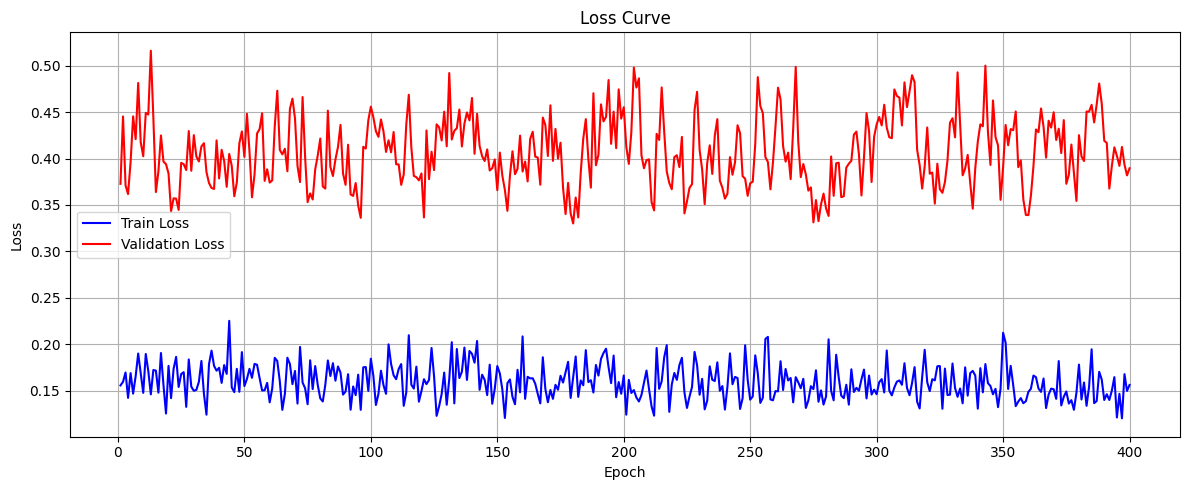

In [80]:
num_epochs = len(list_avg_train_loss_ats)
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

axes.plot(epochs, list_avg_train_loss_ats, label='Train Loss', color='blue')
axes.plot(epochs, list_avg_val_loss_ats, label='Validation Loss', color='red')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.set_title('Loss Curve')
axes.legend()
axes.grid(True)

plt.tight_layout()
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Observations :</font>**  

- **Overfitting**: The validation loss remains high and fluctuates significantly, while the training loss is much lower and stable.
- **Poor Generalization**: The model does not improve its validation performance despite training for multiple epochs.
- **Validation Instability**: The validation loss is not following a clear decreasing trend, suggesting inconsistency in learning.

---

**<font color='green'>Explainations :</font>**  

- **Small Validation Set**: The validation loader contains only **10 patients**, which may not represent the overall data distribution well.
- **Small Training Batch per Epoch**: Only **20 patients per epoch**, selected randomly, which can lead to high variance in training.
- **Unstable Temperature Learning**: Since only the temperature head is trained, the model might struggle to find a good calibration.

</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">To improve the training :</span>**  

- **Increase Training Data per Epoch**: Instead of 20 patients per epoch, Increase this to **50 or more** to improve stability.
- **Expand Validation Set**: Increase the **number of patients in validation** (e.g., from 10 to 30 or more).
- **Increase the Number of Epochs**: Allow more training iterations, e.g., **100+ epochs**, to stabilize learning.
- **Reduce Learning Rate**: A **smaller learning rate (e.g., 1e-5 instead of 1e-4)** can help avoid drastic updates.
- **Regularization on Temperature Head**: Add a **stronger constraint** on the temperature map to avoid extreme scaling (e.g., L2 regularization).
- **Change Sampling Strategy**: Instead of random sampling at each epoch, ensure a more structured **patient selection strategy** to cover all variations.

</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">How to improve our ATS approach :</span>**  

There are several factors behind difficulties of pixel-wise Adaptive Temperature Scaling (ATS) to lower the ECE. First, introducing a per-pixel temperature substantially **increases the number of parameters**, often causing overfitting or instability—especially if you train on the same data used for the main model. Second, the Expected Calibration Error (ECE) calculation typically involves **non-differentiable** operations (e.g., argmax, binning), so training with **just Cross-Entropy** does not directly drive calibration improvements. Finally, the basic regularization that encourages temperatures to stay around 1 may be insufficient to properly constrain the temperature map, allowing it to drift without truly alleviating overconfidence.


To achieve better calibration, it is recommended 
* (1) **to separate network training** (on one dataset) from calibration (on a distinct validation set) to avoid simply “re-learning” the training data, 
* (2) to employ a loss function more directly tied to calibration and differentiable—such as **the Brier Score**,
* (3) to **strengthen regularization** (e.g., $(T_{ij}-1)^2$) so that temperatures remain near 1. 


</div>

##### **3.c.3. Calibration results: ECE + Temperature map examples**

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ats = UNetWithATS(n_channels=1, n_classes=4).to(device)

checkpoint_path = "/content/drive/MyDrive/modeles/model_unet_ats.pth"
model_ats.load_state_dict(torch.load(checkpoint_path, map_location=device))

print("Model UNet loaded !")

Model UNet loaded !


<ipython-input-81-93056e619b98>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ats.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [82]:
# Before Calibration: Measure ECE without calibration
model.eval()
with torch.no_grad():
    logits_list, labels_list = [], []
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        logits = model(X_test)  # Raw model logits
        logits_list.append(logits.cpu())
        labels_list.append(y_test.cpu())

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)
    probs_before = torch.softmax(logits, dim=1)  # Probabilities before calibration
    ece_before = expected_calibration_error(probs_before, labels)
    print(f"ECE before calibration: {ece_before:.4f}")
    print("")

# Calibration with Classical Temperature Scaling
optimal_temperature = find_best_temperature(model, test_loader, loss_fn, device)
print(f"Optimal temperature found (Classical TS): {optimal_temperature:.4f}")

# After Classical TS Calibration: Recalculate ECE
with torch.no_grad():
    scaled_logits_TS = logits / optimal_temperature  # Logits adjusted using TS
    probs_after_TS = torch.softmax(scaled_logits_TS, dim=1)  # Probabilities after TS
    ece_after_TS = expected_calibration_error(probs_after_TS, labels)
    print(f" ECE after Classical Temperature Scaling: {ece_after_TS:.4f}")
    print("")

# After ATS Calibration: Recalculate ECE
model_ats.eval()
with torch.no_grad():
    logits_list_ats, labels_list_ats = [], []
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        scaled_logits_ats, _ = model_ats(X_test)  # Logits adjusted pixel-wise by ATS
        logits_list_ats.append(scaled_logits_ats.cpu())
        labels_list_ats.append(y_test.cpu())

    logits_ats = torch.cat(logits_list_ats)
    labels_ats = torch.cat(labels_list_ats)
    probs_after_ats = torch.softmax(logits_ats, dim=1)  # Probabilities after ATS
    ece_after_ats = expected_calibration_error(probs_after_ats, labels_ats)
    print(f" ECE after Adaptive Temperature Scaling (ATS): {ece_after_ats:.4f}")


ECE before calibration: 0.1029

Optimal temperature found (Classical TS): 1.2272
 ECE after Classical Temperature Scaling: 0.0914

 ECE after Adaptive Temperature Scaling (ATS): 0.0659


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

The ATS calibration is quite a **<font color='green'>success</font>**! We get an improvement of the ECE. But, we cannot be satisfied of our method as the training is very unstable leading to **non robust method**.

</div>

In [83]:
def visualize_4_examples_ats(
    model,      # Standard (non-calibrated) model (UNet)
    model_ats,  # ATS model (UNetWithATS) producing scaled_logits and temp_map
    test_loader,
    device
):
    """
    1) Iterates over test_loader, selecting a slice every 30 iterations.
    2) Selects 4 slices where the predicted mask (argmax without calibration) is not entirely class 0.
    3) For each selected slice, retrieves:
       - T1ce MRI scan
       - Predicted segmentation mask (without calibration)
       - Confidence map without calibration (from the standard model)
       - Heatmap (temp_map) from model_ats
       - Calibrated confidence map (logits_no_cal / temp_map)
    4) Displays a 4x5 figure (4 examples, 5 columns):
       Col 0: T1ce MRI
       Col 1: Predicted Mask (No Cal)
       Col 2: Confidence (No Cal)
       Col 3: Heatmap (temp_map)
       Col 4: Confidence (ATS Calibration)
    """
    model.eval()
    model_ats.eval()

    found_examples = []

    # Define indices to be tested (0, 30, 60, ...)
    selected_indices = list(range(0, 200, 40))  # Adjust based on dataset

    with torch.no_grad():
        for i, (X_test, _) in enumerate(test_loader):
            # Check if the current index is one of the selected indices
            if i not in selected_indices:
                continue  # Skip iteration if not selected

            # Move to the device
            X_test = X_test.to(device).float()

            # 1) Standard logits (without calibration)
            logits_no_cal = model(X_test)  # Shape: (1, n_classes, H, W)
            pred_mask = logits_no_cal.argmax(dim=1)  # Shape: (1, H, W)

            # Check if segmentation contains at least one non-zero pixel
            if (pred_mask != 0).any():
                # 2) Confidence map (without calibration)
                probs_no_cal = F.softmax(logits_no_cal, dim=1)
                conf_no_cal, _ = probs_no_cal[0].max(dim=0)  # Shape: (H, W)

                # 3) Heatmap & scaled logits (ATS)
                scaled_logits_ats, temp_map = model_ats(X_test)
                # temp_map: Shape (1, 1, H, W)
                # scaled_logits_ats: Shape (1, n_classes, H, W)

                # 4) Confidence map after ATS calibration
                probs_cal = F.softmax(scaled_logits_ats, dim=1)
                conf_cal, _ = probs_cal[0].max(dim=0)

                # Store results for visualization
                found_examples.append((
                    X_test[0, 0].cpu().numpy(),       # T1ce MRI scan
                    pred_mask[0].cpu().numpy(),       # Predicted mask (No Cal)
                    conf_no_cal.cpu().numpy(),        # Confidence (No Cal)
                    temp_map[0, 0].cpu().numpy(),     # Heatmap (temp_map)
                    conf_cal.cpu().numpy(),           # Confidence (ATS Calibration)
                    i                                 # Slice index
                ))

                if len(found_examples) == 4:
                    break  # Stop as soon as 4 valid slices are found

    # Create a 4x5 figure for comparison
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
    fig.suptitle("Comparison: T1ce / Pred Mask / Confidence (No Cal) / Heatmap / Confidence (ATS)", fontsize=16)

    for row, (t1ce, pred_mask, conf_nocal, tmap, conf_cal, idx) in enumerate(found_examples):
        # 0) T1ce MRI scan
        axes[row, 0].imshow(t1ce, cmap='gray')
        axes[row, 0].set_title(f"T1ce (slice #{idx})", fontsize=10)
        axes[row, 0].axis('off')

        # 1) Predicted Mask (No Calibration)
        axes[row, 1].imshow(pred_mask, cmap='jet')
        axes[row, 1].set_title("Predicted Mask (No Cal)", fontsize=10)
        axes[row, 1].axis('off')

        # 2) Confidence (No Calibration)
        im_no_cal = axes[row, 2].imshow(conf_nocal, cmap='viridis', vmin=0.5, vmax=1)
        axes[row, 2].set_title("Confidence (No Cal)", fontsize=10)
        axes[row, 2].axis('off')
        plt.colorbar(im_no_cal, ax=axes[row, 2], fraction=0.046, pad=0.04)

        # 3) Heatmap (temp_map)
        im_tmap = axes[row, 3].imshow(tmap, cmap='jet')
        axes[row, 3].set_title("Heatmap (temp_map)", fontsize=10)
        axes[row, 3].axis('off')
        plt.colorbar(im_tmap, ax=axes[row, 3], fraction=0.046, pad=0.04)

        # 4) Confidence after ATS Calibration
        im_cal = axes[row, 4].imshow(conf_cal, cmap='viridis', vmin=0.5, vmax=1)
        axes[row, 4].set_title("Confidence (ATS)", fontsize=10)
        axes[row, 4].axis('off')
        plt.colorbar(im_cal, ax=axes[row, 4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


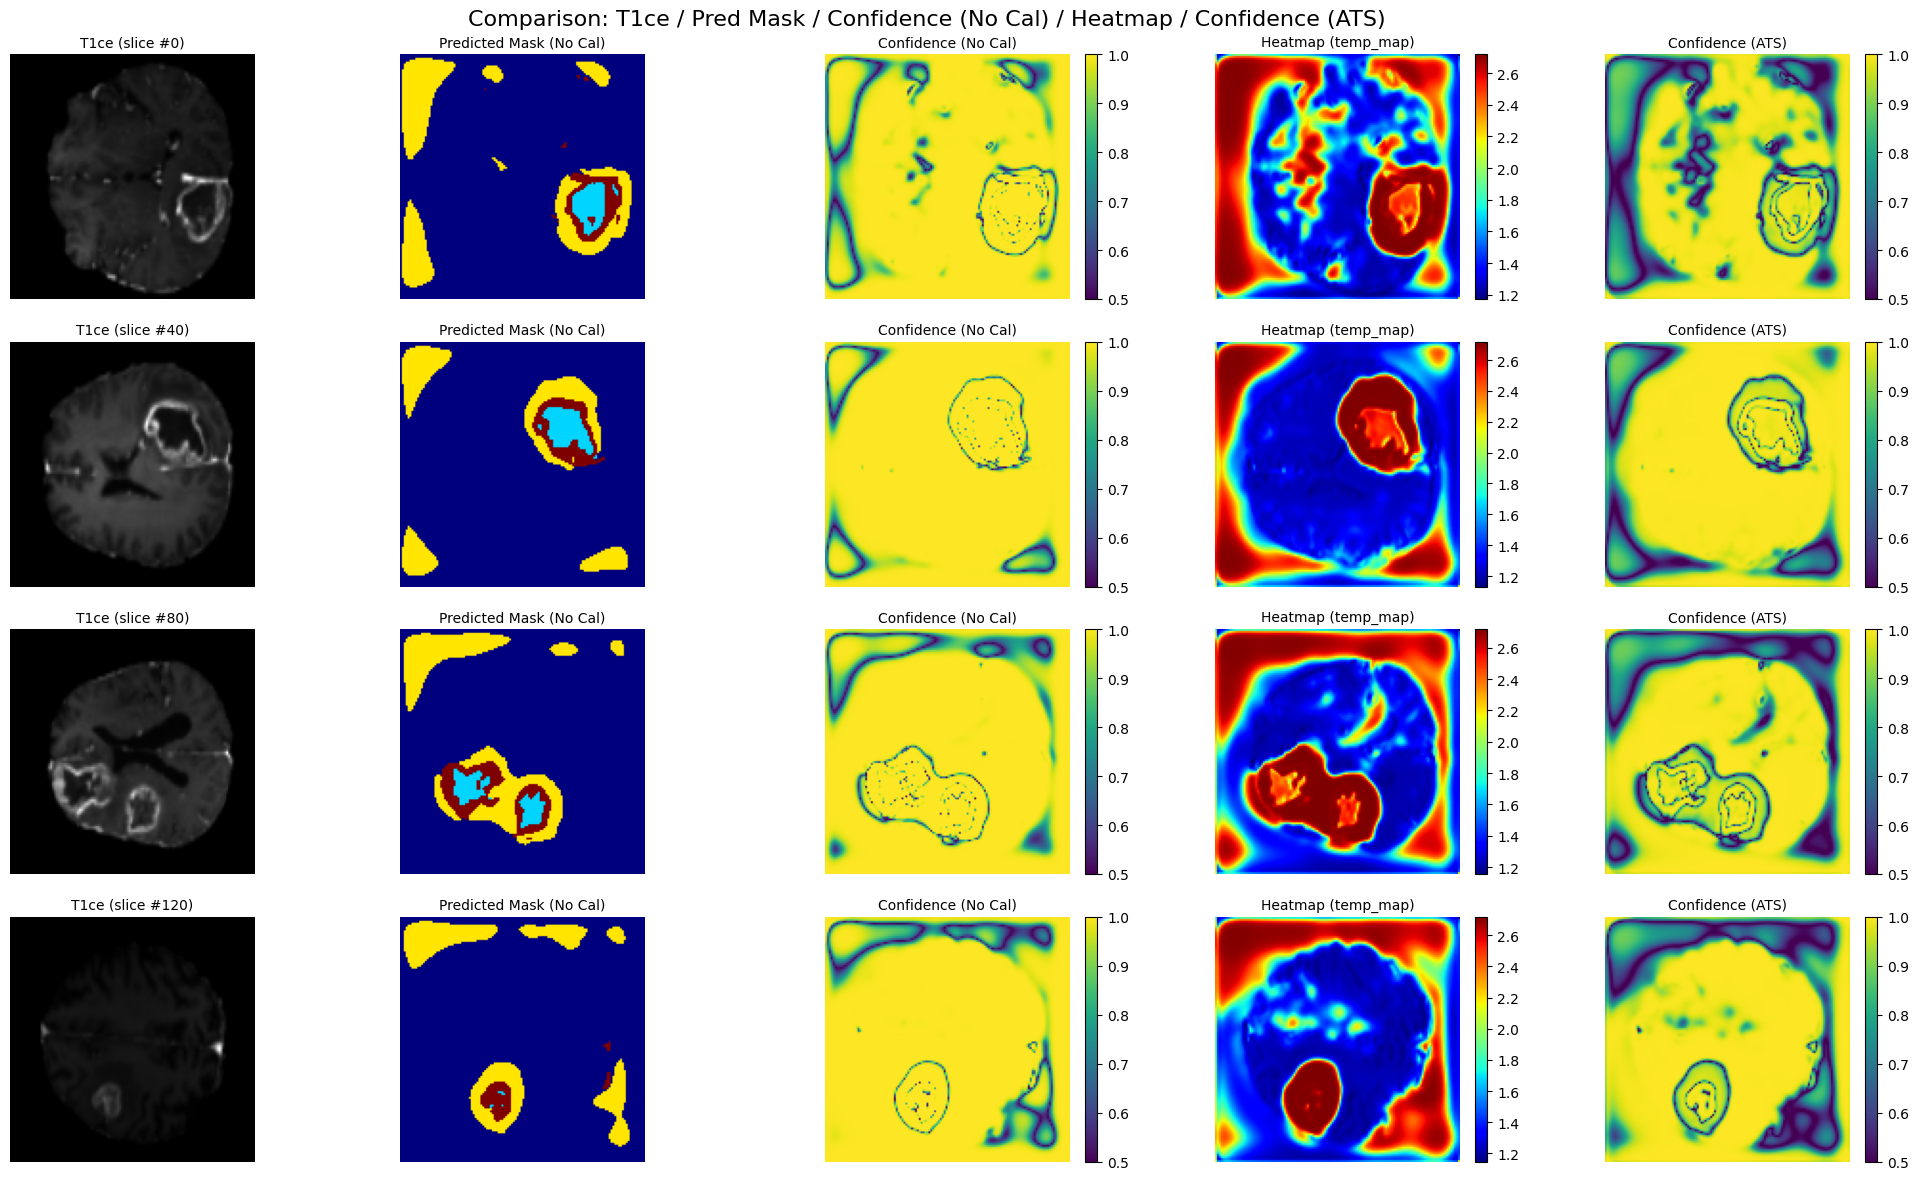

In [84]:
visualize_4_examples_ats(
    model,
    model_ats,
    test_loader,
    device)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

Nevertheless, even if the per-pixel training of the temperature parameter T was not fully optimal, the resulting temperature maps are still meaningful!

* We can clearly observe that areas where the background was misclassified (class 1 instead of 0) have been identified by our approach, which correctly detected the model's **overconfidence** in these regions. 
* Moreover, the model is also deemed **overconfident** in areas where the tumor is located. 
* As a result, the confidence maps obtained after applying the temperature maps provide a **much more accurate and realistic representation**.

</div>

#### **3.d. Monte Carlo Dropout**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;"> Monte Carlo Dropout method</span>**  

**Calibration and Uncertainty Estimation**

Monte Carlo (MC) Dropout is a technique that enables **uncertainty estimation** in deep learning models by leveraging stochasticity in dropout layers. Unlike standard dropout, which is only active during training, MC Dropout **keeps dropout active** during inference, allowing multiple stochastic forward passes for each input.

This approach serves two key purposes:

* **Model Calibration**: By averaging multiple softmax probability outputs, MC Dropout helps mitigate overconfidence in predictions, leading to better calibration.
* **Uncertainty Estimation**: By computing the standard deviation across predictions, it generates an uncertainty map, which highlights regions where the model is less confident.

Unlike a standard U-Net segmentation model, where the predicted mask is deterministic, in MC Dropout, the predicted segmentation mask varies across different passes, providing a more nuanced view of the model's uncertainty.

---

**Code implementation**

* To implement MC Dropout, we extend the U-Net model by ensuring that Dropout layers remain active during inference.
* To leverage MC Dropout, we perform multiple stochastic forward passes and aggregate predictions

</div>

In [67]:
def mc_dropout_predictions(model, X, n_forward_passes=30):
    """
    Performs multiple forward passes on the same input `X` using MC Dropout.

    Returns:
    - The mean of the predictions
    - The standard deviation of the predictions (uncertainty)
    """
    model.enable_mc_dropout()  # Activates Dropout even in evaluation mode
    preds = []

    with torch.no_grad():
        for _ in range(n_forward_passes):
            logits = model(X)  # Generates different logits at each pass
            probs = torch.softmax(logits, dim=1)  # Converts logits to probabilities
            preds.append(probs.unsqueeze(0))  # Adds a batch dimension

    preds = torch.cat(preds, dim=0)  # Stack predictions (n_passes, batch, n_classes, H, W)
    mean_preds = preds.mean(dim=0)  # Mean of the predictions
    std_preds = preds.std(dim=0)  # Standard deviation of predictions (uncertainty)

    return mean_preds, std_preds


In [38]:
class MC_Dropout_UNet(nn.Module):
    """
    Monte Carlo Dropout U-Net.

    This model extends a standard U-Net by enabling Monte Carlo (MC) Dropout,
    allowing uncertainty estimation through multiple stochastic forward passes.
    """
    def __init__(self, n_channels, n_classes, dropout_prob=0.5):
        super(MC_Dropout_UNet, self).__init__()
        self.unet = UNet(n_channels, n_classes, dropout_prob=dropout_prob)

    def forward(self, x):
        return self.unet(x)

    def enable_mc_dropout(self):
        """
        Forces Dropout to remain active during inference.

        Ensures that Dropout layers behave as in training mode, even when the
        model is set to evaluation mode. This is required for MC Dropout-based
        uncertainty estimation.
        """
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()  # Activate Dropout even in evaluation mode


In [85]:
# Define the computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the MC Dropout U-Net model
model_mc_dropout = MC_Dropout_UNet(n_channels=1, n_classes=4, dropout_prob=0.5).to(device)

# Load the pre-trained weights into the U-Net submodule
checkpoint_path = "/content/drive/MyDrive/modeles/model_unet.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model_mc_dropout.unet.load_state_dict(state_dict)


def evaluate_mc_dropout(model_mc_dropout, val_loader, device, n_passes_list):
    """
    Evaluates MC Dropout-based calibration for different numbers of forward passes.

    Computes:
    - Expected Calibration Error (ECE)
    - Dice Coefficient
    - Intersection over Union (IoU)

    Parameters:
    - model_mc_dropout: The U-Net model with MC Dropout enabled.
    - val_loader: The validation data loader.
    - device: The computing device (CPU/GPU).
    - n_passes_list: List of MC Dropout forward pass values to evaluate.

    Returns:
    - results: Dictionary containing ECE, Dice, and IoU for each n_forward_passes.
    """

    model_mc_dropout.eval()
    results = {}

    for n_passes in n_passes_list:
        print(f" Evaluating with n_forward_passes = {n_passes}")

        logits_list, labels_list, preds_list = [], [], []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)

                # MC Dropout: multiple forward passes to estimate uncertainty
                mean_probs, _ = mc_dropout_predictions(model_mc_dropout, X_val, n_forward_passes=n_passes)

                # Convert probabilities to predicted class labels
                preds = mean_probs.argmax(dim=1)  # (B, H, W)

                logits_list.append(mean_probs.cpu())  # Average probabilities
                labels_list.append(y_val.cpu())
                preds_list.append(preds.cpu())  # Predicted segmentation masks

        # Concatenate results
        mean_probs = torch.cat(logits_list)
        labels = torch.cat(labels_list)
        preds = torch.cat(preds_list)

        # Compute ECE
        ece_mc_dropout = expected_calibration_error(mean_probs, labels)

        # Compute Dice and IoU coefficients
        dice_score = dice_coef(labels, preds)
        iou_score = iou_coef(labels, preds)

        # Store results
        results[n_passes] = {
            "ECE": ece_mc_dropout,
            "Dice": dice_score,
            "IoU": iou_score
        }

        print(f" ECE: {ece_mc_dropout:.4f}, Dice: {dice_score:.4f}, IoU: {iou_score:.4f}")

    return results

# Define the range of n_forward_passes
n_forward_passes_list = [1, 5, 10, 30, 50, 100]

# Run evaluation
results = evaluate_mc_dropout(model_mc_dropout, test_loader, device, n_forward_passes_list)


<ipython-input-85-b77833c4f1c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)
<ipython-input-67-296245f7ced

 Evaluating with n_forward_passes = 1
 ECE: 0.0368, Dice: 0.6685, IoU: 0.5074
 Evaluating with n_forward_passes = 5
 ECE: 0.0258, Dice: 0.6807, IoU: 0.5211
 Evaluating with n_forward_passes = 10
 ECE: 0.0240, Dice: 0.6855, IoU: 0.5265
 Evaluating with n_forward_passes = 30
 ECE: 0.0234, Dice: 0.6859, IoU: 0.5269
 Evaluating with n_forward_passes = 50
 ECE: 0.0233, Dice: 0.6852, IoU: 0.5263
 Evaluating with n_forward_passes = 100
 ECE: 0.0231, Dice: 0.6862, IoU: 0.5274


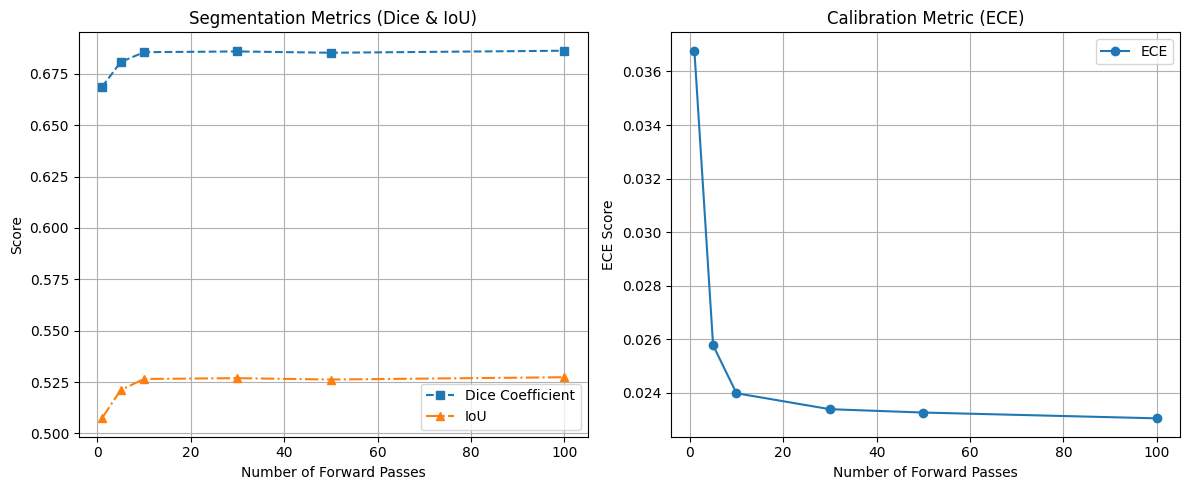

In [89]:
# Extract values from results dictionary
n_passes = sorted(results.keys())  # Ensure values are in order
ece_values = [results[n]["ECE"] for n in n_passes]
dice_values = [results[n]["Dice"] for n in n_passes]
iou_values = [results[n]["IoU"] for n in n_passes]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Dice & IoU
axes[0].plot(n_passes, dice_values, marker='s', label="Dice Coefficient", linestyle='--')
axes[0].plot(n_passes, iou_values, marker='^', label="IoU", linestyle='-.')
axes[0].set_xlabel("Number of Forward Passes")
axes[0].set_ylabel("Score")
axes[0].set_title("Segmentation Metrics (Dice & IoU)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: ECE
axes[1].plot(n_passes, ece_values, marker='o', label="ECE", linestyle='-')
axes[1].set_xlabel("Number of Forward Passes")
axes[1].set_ylabel("ECE Score")
axes[1].set_title("Calibration Metric (ECE)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

We define the number of stochastic forward passes as n_mc. The two graphs below illustrate two key effects of the Monte Carlo Dropout method as the number of passes increases.

* (1) The Dice and IoU coefficients slightly increase, indicating an improvement in the predicted segmentation mask.

* (2) The ECE drops drastically from 1 to 30 passes and continues to decrease steadily.

Monte Carlo Dropout is by far **<font color='green'>the best calibration method</font>** in our study! 

* For 100 passes: ECE (MC Dropout) = **<font color='green'>0.0231</font>**
* ECE (without calibration) = 0.1029
* ECE (TS) = 0.0914
* ECE (ATS) = 0.0659


</div>

In [86]:
def visualize_mc_dropout_examples_test(
    model1,# UNet model (loaded)
    model2,# MC Dropout UNet model (loaded)
    test_loader,      # Test DataLoader
    device,
    n_forward_passes=30,
    num_examples=4
):
    """
    Displays 7 subplots (1x7) for `num_examples` images selected every 30 iterations:
      - T1ce (original image)
      - Ground Truth mask
      - Predicted mask (without MC Dropout)
      - Predicted mask (with MC Dropout)
      - Confidence map (without MC Dropout)
      - Confidence map (with MC Dropout)
      - Uncertainty map (standard deviation from MC Dropout)
    """

    model1.eval

    model2.eval()
    model2.enable_mc_dropout()  # Force Dropout to remain active during evaluation

    examples_shown = 0
    selected_indices = list(range(0, 1000, 40))

    for i, (X_batch, y_batch) in enumerate(test_loader):
        if i not in selected_indices:
            continue  # Skip iteration if not selected

        B = X_batch.size(0)

        for j in range(B):
            x_single = X_batch[j].unsqueeze(0).to(device)  # (1, 1, H, W)
            y_single = y_batch[j].to(device)               # (H, W)

            # 1) Prediction without MC Dropout
            logits_no_mc = model1(x_single)  # (1, n_classes, H, W)
            pred_mask_no_mc = logits_no_mc.argmax(dim=1).squeeze(0).detach().cpu().numpy()

            # Confidence map without MC Dropout
            probs_no_mc = F.softmax(logits_no_mc, dim=1)
            conf_map_no_mc = probs_no_mc.max(dim=1)[0].squeeze(0).detach().cpu().numpy()

            # 2) Prediction with MC Dropout
            mean_probs, std_probs = mc_dropout_predictions(model2, x_single, n_forward_passes)

            # Predicted mask (MC Dropout)
            pred_mask_mc = mean_probs.argmax(dim=1).squeeze(0).detach().cpu().numpy()

            # Confidence map (MC Dropout)
            conf_map_mc = mean_probs.max(dim=1)[0].squeeze(0).detach().cpu().numpy()

            # Uncertainty map (MC Dropout)
            uncertainty_map = std_probs.max(dim=1)[0].squeeze(0).detach().cpu().numpy()

            # Prepare raw data
            t1ce_image = x_single[0, 0].cpu().numpy()  # (H, W)
            mask_gt    = y_single.cpu().numpy()        # (H, W)

            # Create a figure with 7 subplots
            fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(24, 4))

            axes[0].imshow(t1ce_image, cmap='gray')
            axes[0].set_title("T1ce")
            axes[0].axis("off")

            axes[1].imshow(mask_gt, cmap='jet', vmin=0, vmax=3)
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(pred_mask_no_mc, cmap='jet', vmin=0, vmax=3)
            axes[2].set_title("Predicted Mask (No MC)")
            axes[2].axis("off")

            axes[3].imshow(pred_mask_mc, cmap='jet', vmin=0, vmax=3)
            axes[3].set_title("Predicted Mask (MC)")
            axes[3].axis("off")

            im_conf_no_mc = axes[4].imshow(conf_map_no_mc, cmap='viridis', vmin=0.5, vmax=1)
            axes[4].set_title("Confidence (No MC)")
            axes[4].axis("off")
            plt.colorbar(im_conf_no_mc, ax=axes[4], fraction=0.046, pad=0.04)

            im_conf_mc = axes[5].imshow(conf_map_mc, cmap='viridis', vmin=0.5, vmax=1)
            axes[5].set_title("Confidence (MC)")
            axes[5].axis("off")
            plt.colorbar(im_conf_mc, ax=axes[5], fraction=0.046, pad=0.04)

            im_unc = axes[6].imshow(uncertainty_map, cmap='jet')
            axes[6].set_title("Uncertainty (MC)")
            axes[6].axis("off")
            plt.colorbar(im_unc, ax=axes[6], fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.show()

            examples_shown += 1
            if examples_shown >= num_examples:
                return  # Stop after num_examples selected images


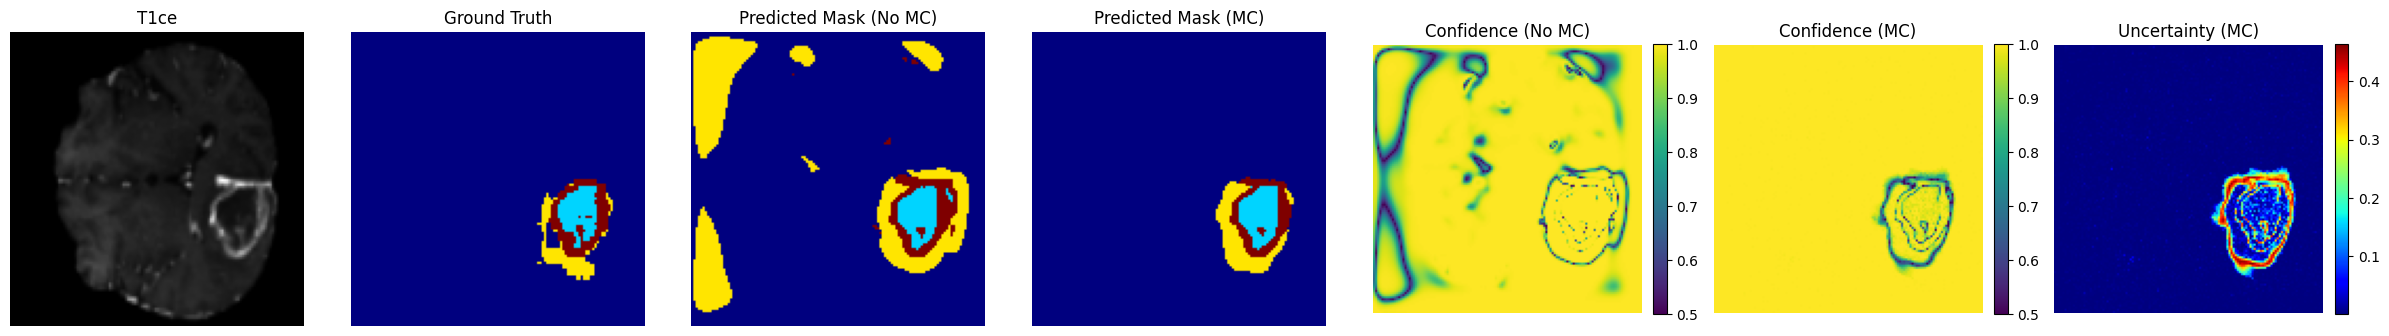

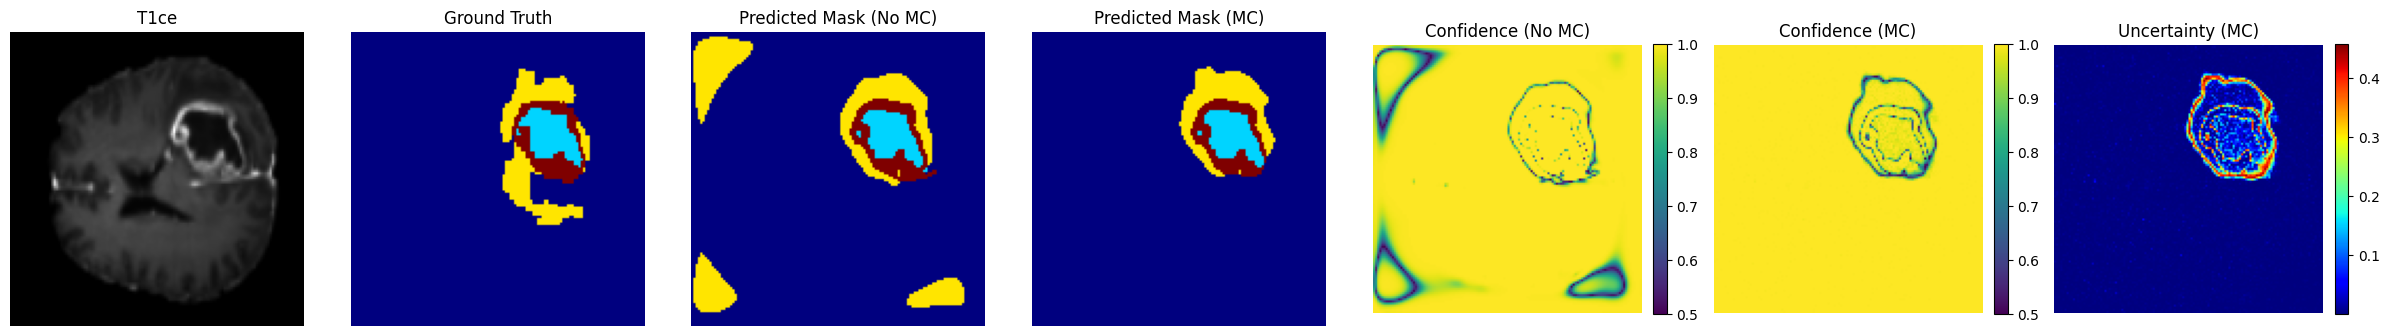

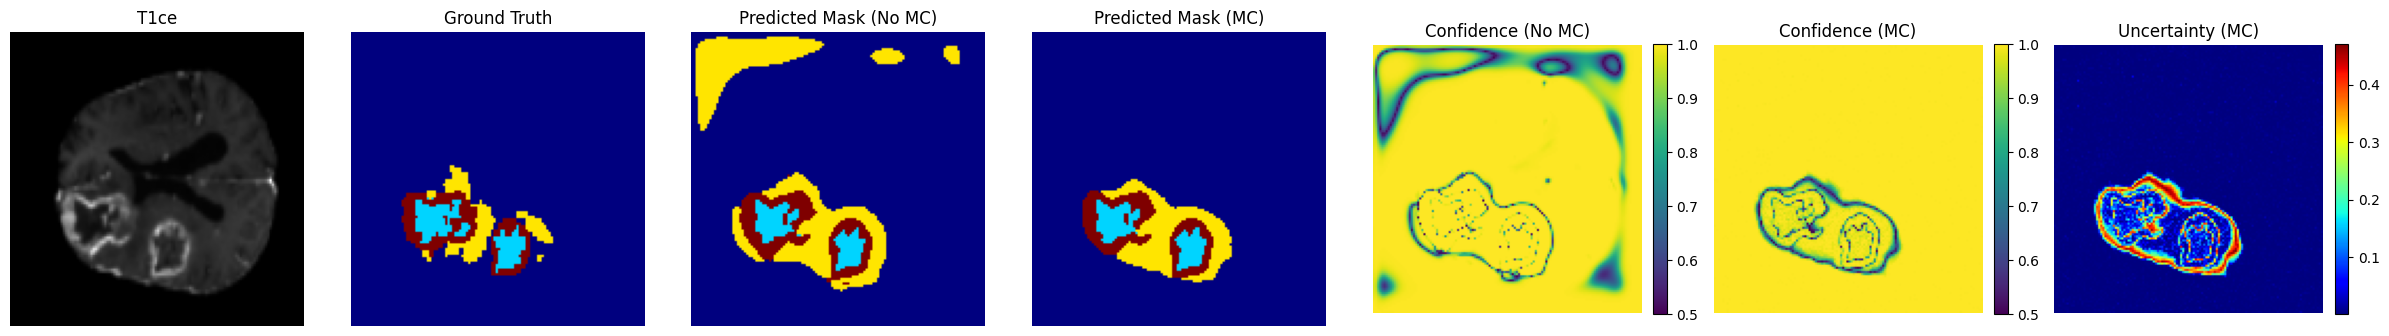

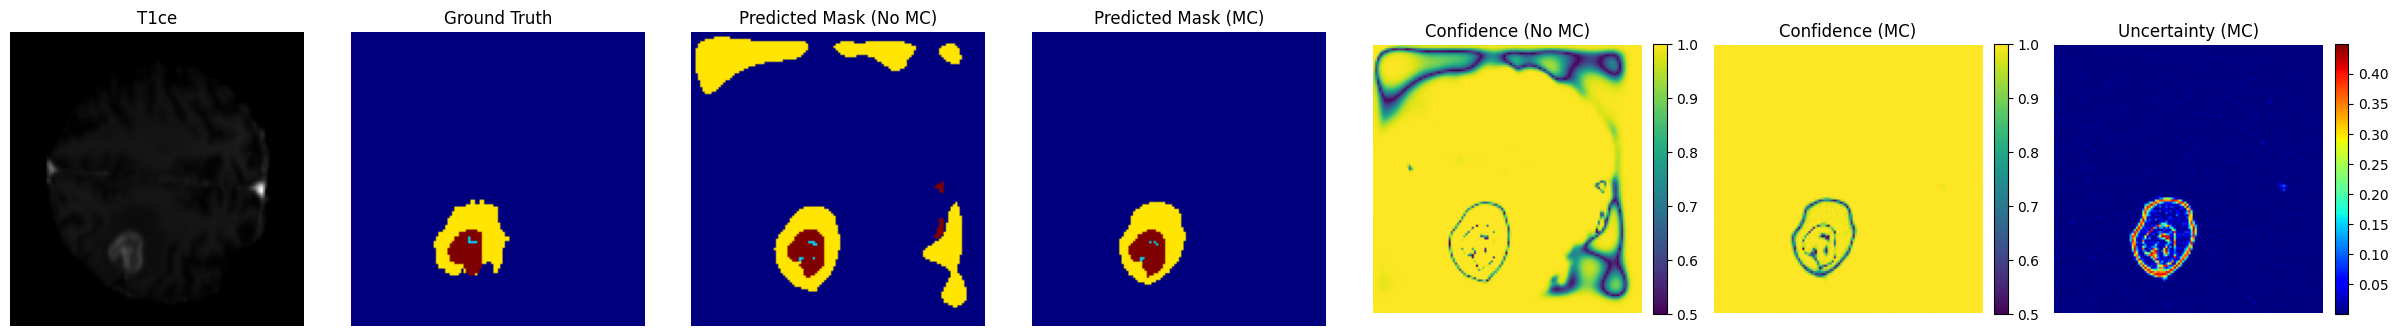

In [87]:
visualize_mc_dropout_examples_test(model, model_mc_dropout, test_loader, device,
                              n_forward_passes=50, num_examples=4)


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. The predicted mask using MC Dropout is more accurate. Specifically, it has stopped misclassifying the black background as class 1 (yellow).

2. This technique allows us to visualize the uncertainty map. We observe that the confidence map and the uncertainty map align, which is reassuring—where the model is less confident, it is also more uncertain. We definitely do not want a model that is both overconfident and uncertain!

3. The uncertainty regions correspond to the class transition zones in the predicted mask, meaning they align with the boundaries of the necrotic areas, edema, and tumor propagation zones.

</div>

### **4. Segmentation with a BNN UNet Model**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;"> BNN definition</span>**  

**Bayesian Neural Networks (BNNs)** incorporate Bayesian inference into traditional neural networks
by treating each network parameter (such as weights) as a **probability distribution** rather than
a single fixed value. This approach allows the model to naturally capture uncertainty in its
predictions, since each weight represents a range of plausible values. As a result, BNNs can
help improve robustness against overfitting, provide **better uncertainty estimates** in predictions,
and offer a more interpretable framework for decision-making compared to standard neural networks.

In our case, the model's weights follow a Gaussian distribution with mean (μ) and standard deviation (σ).
This parameterization offers a flexible way to capture the variability in model parameters, providing
a principled method for representing uncertainty in both model structure and predictions.

![BNN principle](bnn.png)

</div>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import math
import torch.optim as optim




#### **4.a. Model Definition**

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px;">

**<span style="color: orange;"> BNN UNet architecture</span>**  

Our BNN model adopts the same U-Net structure (with an encoder-decoder architecture, skip connections, etc.) than the previous CNN model, the only key difference is that the first U-Net is a standard deterministic CNN model, whereas the second U-Net is a Bayesian model that places a distribution over the weights in each convolutional layer.

---

**<span style="color: orange;"> The Bayesian Loss Function</span>**

In Bayesian neural networks, we often combine the **negative log-likelihood** (or any data fidelity term) with a **KL-divergence** term to regularize the learned posterior distribution towards a chosen prior distribution. A typical form of the Bayesian loss can be written as:

$$
\mathcal{L}(\theta) = \underbrace{-\log p(\mathbf{y} \mid \mathbf{x}, \theta)}_{\text{Data fidelity term (e.g., cross-entropy)}} 
\;+\; \beta \, \underbrace{\text{KL}\big[q(\theta) \,\|\, p(\theta)\big]}_{\text{Regularization term}}
$$

where:

- $\theta$ represents the network parameters (i.e., the distributions over weights in the Bayesian setting).
- $p(\mathbf{y} \mid \mathbf{x}, \theta)$ is the likelihood of the observed data given the parameters $\theta$.  
- $\text{KL}[q(\theta)\,\|\,p(\theta)]$ measures the discrepancy between the approximate posterior $q(\theta)$ and the prior $p(\theta)$.  
- $\beta$ is a coefficient that balances the importance of the KL term versus the data fidelity term.

This combination encourages the model to fit the data well while also preventing overconfidence by keeping the learned parameter distributions close to their prior. Effectively, it provides a principled way to capture and account for uncertainty in the model’s predictions.

</div>

In [90]:

# ==================================================================
# 1) Definition of a Bayesian convolution layer
# ==================================================================
class BayesianConv2d(nn.Module):
    """
    Simplified implementation of a Bayesian Convolution:
      - We consider a distribution over weights W ~ N(mu, sigma).
      - We approximate sigma via a 'rho' parameter (sigma = log(1 + exp(rho))).
      - We sample weights during the forward pass (reparametrization trick).
      - We compute the KL-divergence term for each layer, to be added to the loss.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 prior_sigma=1.0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Posterior parameters (µ and rho), initialized conventionally
        self.weight_mu = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.weight_rho = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))

        # Same for the bias, making it Bayesian as well
        self.bias_mu = nn.Parameter(torch.Tensor(out_channels))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels))

        # Define the prior (Gaussian) over weights: p(W) ~ N(0, prior_sigma)
        self.prior_sigma = prior_sigma
        self.prior = Normal(0, prior_sigma)

        # Initialization
        self.reset_parameters()

    def reset_parameters(self):
        """
        Standard initialization of the mean and a small initial value for rho.
        """
        nn.init.kaiming_normal_(self.weight_mu)
        nn.init.constant_(self.weight_rho, -3.0)  # petit rho => sigma modérée

        nn.init.constant_(self.bias_mu, 0.0)
        nn.init.constant_(self.bias_rho, -3.0)

    def forward(self, x):
        """
        Forward pass with sampled weights.
        """
        weight = self._sample_weights(self.weight_mu, self.weight_rho)
        bias = self._sample_weights(self.bias_mu, self.bias_rho)

        return F.conv2d(x, weight, bias, stride=self.stride, padding=self.padding)

    def _sample_weights(self, mu, rho):
        """
        Samples W ~ N(mu, sigma) where sigma = log(1 + exp(rho)).
        """
        eps = torch.randn_like(mu)
        sigma = torch.log1p(torch.exp(rho))  # log(1 + exp(rho)) stable numériquement
        return mu + sigma * eps

    def kl_loss_term(self):
        """
        Computes the KL-divergence term for this layer: KL[q(W)||p(W)].
        Under the mean-field approximation:
           KL = sum over W ( log q(W) - log p(W) ).
        """
        weight = self._sample_weights(self.weight_mu, self.weight_rho)
        bias = self._sample_weights(self.bias_mu, self.bias_rho)

        sigma_w = torch.log1p(torch.exp(self.weight_rho))
        sigma_b = torch.log1p(torch.exp(self.bias_rho))

        posterior_w = Normal(self.weight_mu, sigma_w)
        posterior_b = Normal(self.bias_mu, sigma_b)

        log_qw = posterior_w.log_prob(weight).sum() + posterior_b.log_prob(bias).sum()
        log_pw = self.prior.log_prob(weight).sum() + self.prior.log_prob(bias).sum()

        kl = log_qw - log_pw
        return kl

# ==================================================================
# 2) Bayesian Double Convolution Block
# ==================================================================
class BayesianDoubleConv(nn.Module):
    """
    (BayesianConv2d => BatchNorm => ReLU) * 2
    Optionally, Dropout or other mechanisms can be inserted.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.bconv1 = BayesianConv2d(in_channels, mid_channels)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.bconv2 = BayesianConv2d(mid_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.bconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.bconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        return x

    def kl_loss_term(self):
        """
        Aggregates the KL-divergence of both Bayesian layers.
        """
        return self.bconv1.kl_loss_term() + self.bconv2.kl_loss_term()

# ==================================================================
# 3) Bayesian U-Net: Down and Up Blocks
# ==================================================================
class BayesianDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = BayesianDoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

    def kl_loss_term(self):
        return self.conv.kl_loss_term()

class BayesianUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = BayesianDoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

    def kl_loss_term(self):
        return self.conv.kl_loss_term()

# ==================================================================
# 4) Bayesian Output Convolution
# ==================================================================
class BayesianOutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bconv = BayesianConv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        return self.bconv(x)

    def kl_loss_term(self):
        return self.bconv.kl_loss_term()

# ==================================================================
# 5) Bayesian U-Net Model
# ==================================================================
class BayesUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = BayesianDoubleConv(n_channels, 64)
        self.down1 = BayesianDown(64, 128)
        self.down2 = BayesianDown(128, 256)
        self.down3 = BayesianDown(256, 512)
        self.down4 = BayesianDown(512, 512)
        self.up1 = BayesianUp(1024, 256)
        self.up2 = BayesianUp(512, 128)
        self.up3 = BayesianUp(256, 64)
        self.up4 = BayesianUp(128, 64)

        self.outc = BayesianOutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def kl_loss(self):
        """
        Calculates the sum (or average) of KL over all Bayesian layers
        """
        kl_total = 0.0
        # inc
        kl_total += self.inc.kl_loss_term()
        # down
        kl_total += self.down1.kl_loss_term()
        kl_total += self.down2.kl_loss_term()
        kl_total += self.down3.kl_loss_term()
        kl_total += self.down4.kl_loss_term()
        # up
        kl_total += self.up1.kl_loss_term()
        kl_total += self.up2.kl_loss_term()
        kl_total += self.up3.kl_loss_term()
        kl_total += self.up4.kl_loss_term()
        # out
        kl_total += self.outc.kl_loss_term()
        return kl_total


#### **4.b. Model Training**

In [91]:
# -------------------------------
# Model Initialization
# -------------------------------

# Instantiate BayesUNet with 1 input channel and 4 output classes
model_bnn = BayesUNet(n_channels=1, n_classes=4)

# Segmentation loss function (Dice Loss)
dice_loss_fn_bnn = DiceLoss(smooth=1e-5, ignore_background=False)

# Optimizer
optimizer = optim.Adam(model_bnn.parameters(), lr=1e-4, weight_decay=1e-5)

# Coefficient for weighting the KL divergence term
beta = 1e-2  # Adjust based on experimentation

# Total number of model parameters (including biases)
total_params = sum(p.numel() for p in model_bnn.parameters())
print(f"Total model parameters: {total_params}")

34524040


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

It is common practice to divide the KL regularization term by **the total number of model parameters**. This ensures that the KL loss scales properly with model complexity and prevents the regularization from dominating the total loss.

The coefficient **beta = 1e-2** has been chosen so that the KL divergence term and the soft dice loss loss remain within **the same order of magnitude**. This balances the trade-off between regularization and segmentation loss, preventing the model from being overly influenced by either term.

</div>

In [93]:

# -------------------------------
# Device Configuration
# -------------------------------

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training will use GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Training will run on CPU.")
    device = torch.device("cpu")

# Move model to the appropriate device
model_bnn = model_bnn.to(device)

# Lists to track training progress
training_losses = []
validation_losses = []
list_avg_dice_bnn = []
list_avg_iou_bnn = []

# -------------------------------
# Training Loop
# -------------------------------

num_epochs = 400

for epoch in range(num_epochs):
    model_bnn.train()
    train_loss = 0.0

    # Retrieve the corresponding train_loader for this epoch
    train_loader = train_loaders[f"epoch_{epoch}"]

    for X, y in train_loader:
        X, y = X.to(device).float(), y.to(device)

        optimizer.zero_grad()

        # Forward pass
        output_masks = model_bnn(X)

        # Segmentation loss
        ce_loss = dice_loss_fn_bnn(output_masks, y)

        # KL divergence term (sum of KLs across Bayesian layers)
        kl = model_bnn.kl_loss() / total_params

        # Combined loss (CE + beta * KL)
        loss = ce_loss + beta * kl

        # Backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # -------------------------------
    # Validation Phase
    # -------------------------------

    model_bnn.eval()
    val_loss = 0.0
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device).float(), y_val.to(device)

            output_masks_val = model_bnn(X_val)

            # Compute CE + KL loss for validation
            ce_loss_val = dice_loss_fn_bnn(output_masks_val, y_val)
            kl_val = model_bnn.kl_loss()  # Single sample for KL, keeping consistency
            loss_val = ce_loss_val + beta * kl_val / total_params

            val_loss += loss_val.item()

            # Predicted segmentation mask
            pred_val = torch.argmax(output_masks_val, dim=1)

            # Compute evaluation metrics
            dice_val = dice_coef(y_val, pred_val)
            iou_val = iou_coef(y_val, pred_val)
            dice_scores.append(dice_val)
            iou_scores.append(iou_val)

    # Compute average validation loss
    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    # Compute mean Dice and IoU scores
    avg_dice = sum(dice_scores) / len(dice_scores)
    list_avg_dice_bnn.append(avg_dice)

    avg_iou = sum(iou_scores) / len(iou_scores)
    list_avg_iou_bnn.append(avg_iou)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" -> Training Loss:    {avg_train_loss:.4f}")
    print(f" -> Validation Loss:  {avg_val_loss:.4f}")
    print(f" -> Dice (val):       {avg_dice:.4f}")
    print(f" -> IoU (val):        {avg_iou:.4f}")


CUDA is available. GPU will be used for training.
Epoch 1/400
 -> Training Loss:    0.8052
 -> Validation Loss:  0.9666
 -> Dice (val):       0.0527
 -> IoU (val):        0.0284
Epoch 2/400
 -> Training Loss:    0.8066
 -> Validation Loss:  0.9613
 -> Dice (val):       0.0445
 -> IoU (val):        0.0238
Epoch 3/400
 -> Training Loss:    0.8021
 -> Validation Loss:  0.9617
 -> Dice (val):       0.0460
 -> IoU (val):        0.0245
Epoch 4/400
 -> Training Loss:    0.7952
 -> Validation Loss:  0.9823
 -> Dice (val):       0.0431
 -> IoU (val):        0.0229
Epoch 5/400
 -> Training Loss:    0.7927
 -> Validation Loss:  0.9953
 -> Dice (val):       0.0379
 -> IoU (val):        0.0201
Epoch 6/400
 -> Training Loss:    0.7874
 -> Validation Loss:  0.9930
 -> Dice (val):       0.0351
 -> IoU (val):        0.0185
Epoch 7/400
 -> Training Loss:    0.7644
 -> Validation Loss:  0.9726
 -> Dice (val):       0.0373
 -> IoU (val):        0.0200
Epoch 8/400
 -> Training Loss:    0.7856
 -> Validatio

In [94]:
torch.save(model_bnn.state_dict(), "/content/drive/MyDrive/modeles/model_unet_bnn.pth")
print("Modèle UNet BNN saved.")

Modèle UNet BNN saved.


#### **4.c. Learning Curve**

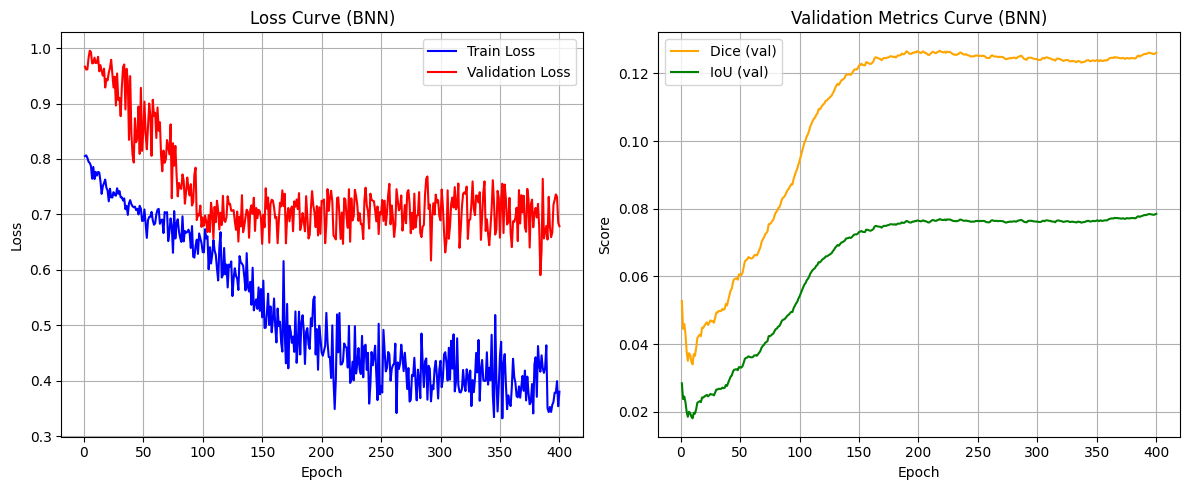

In [95]:
num_epochs = len(training_losses)
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# ------------------
# Subplot 1 (left): Train & Validation Loss
# ------------------
axes[0].plot(epochs, training_losses, label='Train Loss', color='blue')
axes[0].plot(epochs, validation_losses, label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve (BNN)')
axes[0].legend()
axes[0].grid(True)

# ------------------
# Subplot 2 (right): Dice & IoU (Validation)
# ------------------
axes[1].plot(epochs, list_avg_dice_bnn, label='Dice (val)', color='orange')
axes[1].plot(epochs, list_avg_iou_bnn, label='IoU (val)', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics Curve (BNN)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()



<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Observations:</font>**  

- Instability in Training: The validation loss fluctuates significantly, indicating potential instability in the optimization process.
- Plateauing Performance: The Dice and IoU scores remain low, showing that the model struggles to learn meaningful segmentations.
- Large Gap Between Train and Val Loss: The training loss decreases steadily, but the validation loss does not follow the same trend, suggesting overfitting.
- Validation Loss Stagnation: After a certain number of epochs (~150-200), the validation loss does not improve, indicating the model may not generalize well.

---

**<font color='green'>Possible causes:</font>**  

- High Variance in Training: The small validation set (only 10 patients) leads to noisy validation loss and metrics.
- Regularization Too Strong (or Too Weak?):
    - If β is too high, KL regularization dominates, preventing proper learning.
    - If β is too low, the Bayesian prior has minimal effect, making the model behave like a standard U-Net.
- Limited Training Data Per Epoch: Using only 20 patients per epoch might lead to poor generalization.
- Optimization Challenges: Adam optimizer may struggle with the trade-off between segmentation loss and KL regularization.

</div>

<div style="border: 2px solid #007BFF; padding: 10px; border-radius: 5px;">

**<span style="color: blue;">To improve training :</span>**  

- Tune the KL Weight (β): 
    - Reduce β if regularization is too strong, allowing the model to fit the data better.
    - Increase β if the model is not leveraging uncertainty properly.
- Increase Training Data per Epoch: Use more patients per batch to improve generalization.
- Early Stopping or Learning Rate Scheduling: Reduce the learning rate after validation loss plateaus to stabilize training.
- Data Augmentation: Introduce transformations to artificially increase data variability.
- Experiment with Different Optimizers: Try SGD with momentum or look at different learning rate strategies.


</div>


#### **4.d. Results (IoU + Dice, 4 examples with confidence map + uncertainty map and predicted masks)**

In [96]:

def evaluate_bayesian_unet(model, test_loader, device, n_mc=5):
    """
    Evaluates a Bayesian U-Net model using Monte Carlo (MC) Dropout.

    This function computes the average Dice coefficient, IoU (Intersection over Union),
    and Expected Calibration Error (ECE) over the test dataset.

    Steps:
    1) Perform `n_mc` forward passes for each batch to estimate uncertainty.
    2) Compute the mean probability prediction.
    3) Obtain the final segmentation mask as `argmax(mean_probabilities)`.
    4) Compute Dice coefficient, IoU, and ECE.

    Args:
        model (torch.nn.Module): The Bayesian U-Net model.
        test_loader (torch.utils.data.DataLoader): The test dataset loader.
        device (torch.device): The device (CPU/GPU) for computation.
        n_mc (int, optional): Number of Monte Carlo forward passes. Default is 5.

    Returns:
        tuple: Mean Dice coefficient, mean IoU, and mean ECE across the test dataset.
    """

    model.eval()
    dice_scores = []
    iou_scores = []
    ece_scores = []

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val = X_val.to(device).float()  # Shape: (B, 1, 128, 128)
            y_val = y_val.to(device)          # Shape: (B, 128, 128)

            # Store logits from multiple MC forward passes
            mc_logits = []
            for _ in range(n_mc):
                logits = model(X_val)  # (B, 4, 128, 128)
                mc_logits.append(logits)

            # Stack along a new dimension: (n_mc, B, 4, 128, 128)
            mc_logits = torch.stack(mc_logits, dim=0)

            # 1) Convert logits to probabilities using softmax and average over `n_mc`
            #    Shape: (B, 4, 128, 128)
            avg_probs = F.softmax(mc_logits, dim=2).mean(dim=0)

            # 2) Compute Expected Calibration Error (ECE)
            ece_val = expected_calibration_error(avg_probs, y_val, n_bins=10)
            ece_scores.append(ece_val)

            # 3) Compute final prediction mask using `argmax(mean_probabilities)`
            pred_val = avg_probs.argmax(dim=1)  # Shape: (B, 128, 128)

            # 4) Compute Dice and IoU scores
            dice_val = dice_coef(y_val, pred_val)
            iou_val = iou_coef(y_val, pred_val)
            dice_scores.append(dice_val)
            iou_scores.append(iou_val)

    # Compute overall mean scores
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_ece = sum(ece_scores) / len(ece_scores)

    print(f"[Test] Dice: {mean_dice:.4f}")
    print(f"[Test] IoU: {mean_iou:.4f}")
    print(f"[Test] ECE: {mean_ece:.4f}")

    return mean_dice, mean_iou, mean_ece


In [99]:
model_bnn = BayesUNet(n_channels=1, n_classes=4)
model_bnn.load_state_dict(torch.load("/content/drive/MyDrive/modeles/model_unet_bnn.pth"))
model_bnn = model_bnn.to(device)


<ipython-input-99-848d9c9fa257>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_bnn.load_state_dict(torch.load("/content/drive/MyDrive/modeles/model_unet_bnn.pth"))


In [100]:
dice_results = []
iou_results = []
ece_results = []

n_mc_list = [1, 5, 10, 30, 50, 100]
for n_mc in n_mc_list:
  dice, iou, ece = evaluate_bayesian_unet(model_bnn, test_loader, device, n_mc=n_mc)
  dice_results.append(dice)
  iou_results.append(iou)
  ece_results.append(ece)


[Test] Dice: 0.1935
[Test] IoU: 0.1683
[Test] ECE: 0.0650
[Test] Dice: 0.1870
[Test] IoU: 0.1671
[Test] ECE: 0.0608
[Test] Dice: 0.1807
[Test] IoU: 0.1624
[Test] ECE: 0.0598
[Test] Dice: 0.1836
[Test] IoU: 0.1654
[Test] ECE: 0.0587
[Test] Dice: 0.1816
[Test] IoU: 0.1639
[Test] ECE: 0.0585
[Test] Dice: 0.1802
[Test] IoU: 0.1630
[Test] ECE: 0.0588


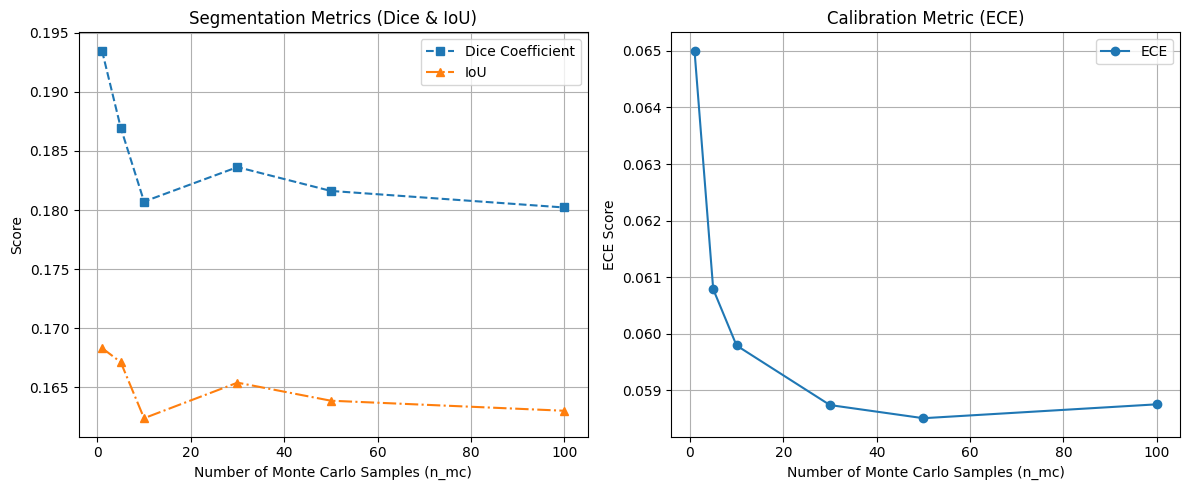

In [101]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Dice & IoU
axes[0].plot(n_mc_list, dice_results, marker='s', label="Dice Coefficient", linestyle='--')
axes[0].plot(n_mc_list, iou_results, marker='^', label="IoU", linestyle='-.')
axes[0].set_xlabel("Number of Monte Carlo Samples (n_mc)")
axes[0].set_ylabel("Score")
axes[0].set_title("Segmentation Metrics (Dice & IoU)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: ECE
axes[1].plot(n_mc_list, ece_results, marker='o', label="ECE", linestyle='-')
axes[1].set_xlabel("Number of Monte Carlo Samples (n_mc)")
axes[1].set_ylabel("ECE Score")
axes[1].set_title("Calibration Metric (ECE)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. The IoU and Dice scores are extremely low, making it difficult to draw any meaningful conclusions from their trends. As we will see later, the model often predicts an all-background mask (only class = 0). These results indicate that the training process requires significant hyperparameter tuning.

2. However, the ECE of the BNN U-Net is lower than that of the CNN U-Net and decreases rapidly as the number of Monte Carlo passes increases. This highlights one of the key advantages of Bayesian Neural Networks: improved calibration and uncertainty estimation.

ECE (CNN) = 0.10   //   ECE (BNN) = 0.0588 with 100 Monte Carlo passes



</div>

In [118]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def visualize_four_examples(model, test_loader, device, n_mc=5):
    """
    Selects 4 examples (images) from the test_loader by iterating with a step of 30
    and displays them in a single figure with 4 rows (one per example) and 5 columns:
      - Column 1: T1ce MRI scan
      - Column 2: Ground truth segmentation mask
      - Column 3: Predicted mask (argmax of mean probabilities)
      - Column 4: Mean confidence map (max probability)
      - Column 5: Uncertainty map (standard deviation)

    Args:
        model (torch.nn.Module): The Bayesian U-Net model.
        test_loader (torch.utils.data.DataLoader): The test dataset loader.
        device (torch.device): The computing device (CPU/GPU).
        n_mc (int, optional): Number of Monte Carlo forward passes. Default is 5.
    """

    model.eval()

    # Select the first four valid examples from the test loader
    examples = []
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        if batch_idx % 40 != 0:
            continue
        examples.append((X_batch[0], y_batch[0]))
        if len(examples) == 4:
            break

    # Create a figure with 4 rows (examples) and 5 columns (visualizations)
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 12))
    fig.suptitle("Monte Carlo Dropout Segmentation Results", fontsize=16)

    # Loop through the 4 selected examples
    for ex_i, (x_single, y_single) in enumerate(examples):
        x_single = x_single.unsqueeze(0).to(device).float()  # Shape: (1, 1, H, W)
        y_single = y_single.to(device)  # Shape: (H, W)

        # Monte Carlo sampling
        mc_probs = []
        with torch.no_grad():
            for _ in range(n_mc):
                logits = model(x_single)  # Shape: (1, 4, H, W)
                probs = F.softmax(logits, dim=1)  # Shape: (1, 4, H, W)
                mc_probs.append(probs)

        # Stack probabilities -> Shape: (n_mc, 1, 4, H, W)
        mc_probs = torch.stack(mc_probs, dim=0)

        # Confidence map: take the maximum probability (most likely class)
        # Shape: (n_mc, 1, H, W)
        mc_maxconf = mc_probs.max(dim=2)[0]

        # Compute the mean and standard deviation pixel-wise over n_mc
        # Shape -> (1, H, W)
        mean_conf = mc_maxconf.mean(dim=0).squeeze(0)  # (H, W)
        std_conf = mc_maxconf.std(dim=0).squeeze(0)    # (H, W)

        # Final prediction (argmax) based on the mean probabilities
        # - Compute the mean over n_mc -> (1, 4, H, W)
        avg_probs = mc_probs.mean(dim=0)
        pred_mask = avg_probs.argmax(dim=1).squeeze(0)  # Shape: (H, W)

        # Column 1: T1ce MRI scan
        axes[ex_i, 0].imshow(x_single.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
        axes[ex_i, 0].set_title(f"Example {ex_i+1} - T1ce MRI", fontsize=10)
        axes[ex_i, 0].axis('off')

        # Column 2: Ground truth segmentation mask
        axes[ex_i, 1].imshow(y_single.cpu().numpy(), cmap='jet', vmin=0, vmax=3)
        axes[ex_i, 1].set_title("Ground Truth Mask", fontsize=10)
        axes[ex_i, 1].axis('off')

        # Column 3: Predicted mask (argmax)
        axes[ex_i, 2].imshow(pred_mask.cpu().numpy(), cmap='jet', vmin=0, vmax=3)
        axes[ex_i, 2].set_title("Predicted Mask (argmax)", fontsize=10)
        axes[ex_i, 2].axis('off')

        # Column 4: Mean confidence map (max probability)
        im4 = axes[ex_i, 3].imshow(mean_conf.cpu().numpy(), cmap='viridis', vmin=0.9, vmax=1)
        axes[ex_i, 3].set_title("Mean Confidence (max prob)", fontsize=10)
        axes[ex_i, 3].axis('off')
        fig.colorbar(im4, ax=axes[ex_i, 3], fraction=0.046, pad=0.04)

        # Column 5: Uncertainty map (std)
        im5 = axes[ex_i, 4].imshow(std_conf.cpu().numpy(), cmap='jet', vmin=0, vmax=0.2)
        axes[ex_i, 4].set_title("Uncertainty Map (std)", fontsize=10)
        axes[ex_i, 4].axis('off')
        fig.colorbar(im5, ax=axes[ex_i, 4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


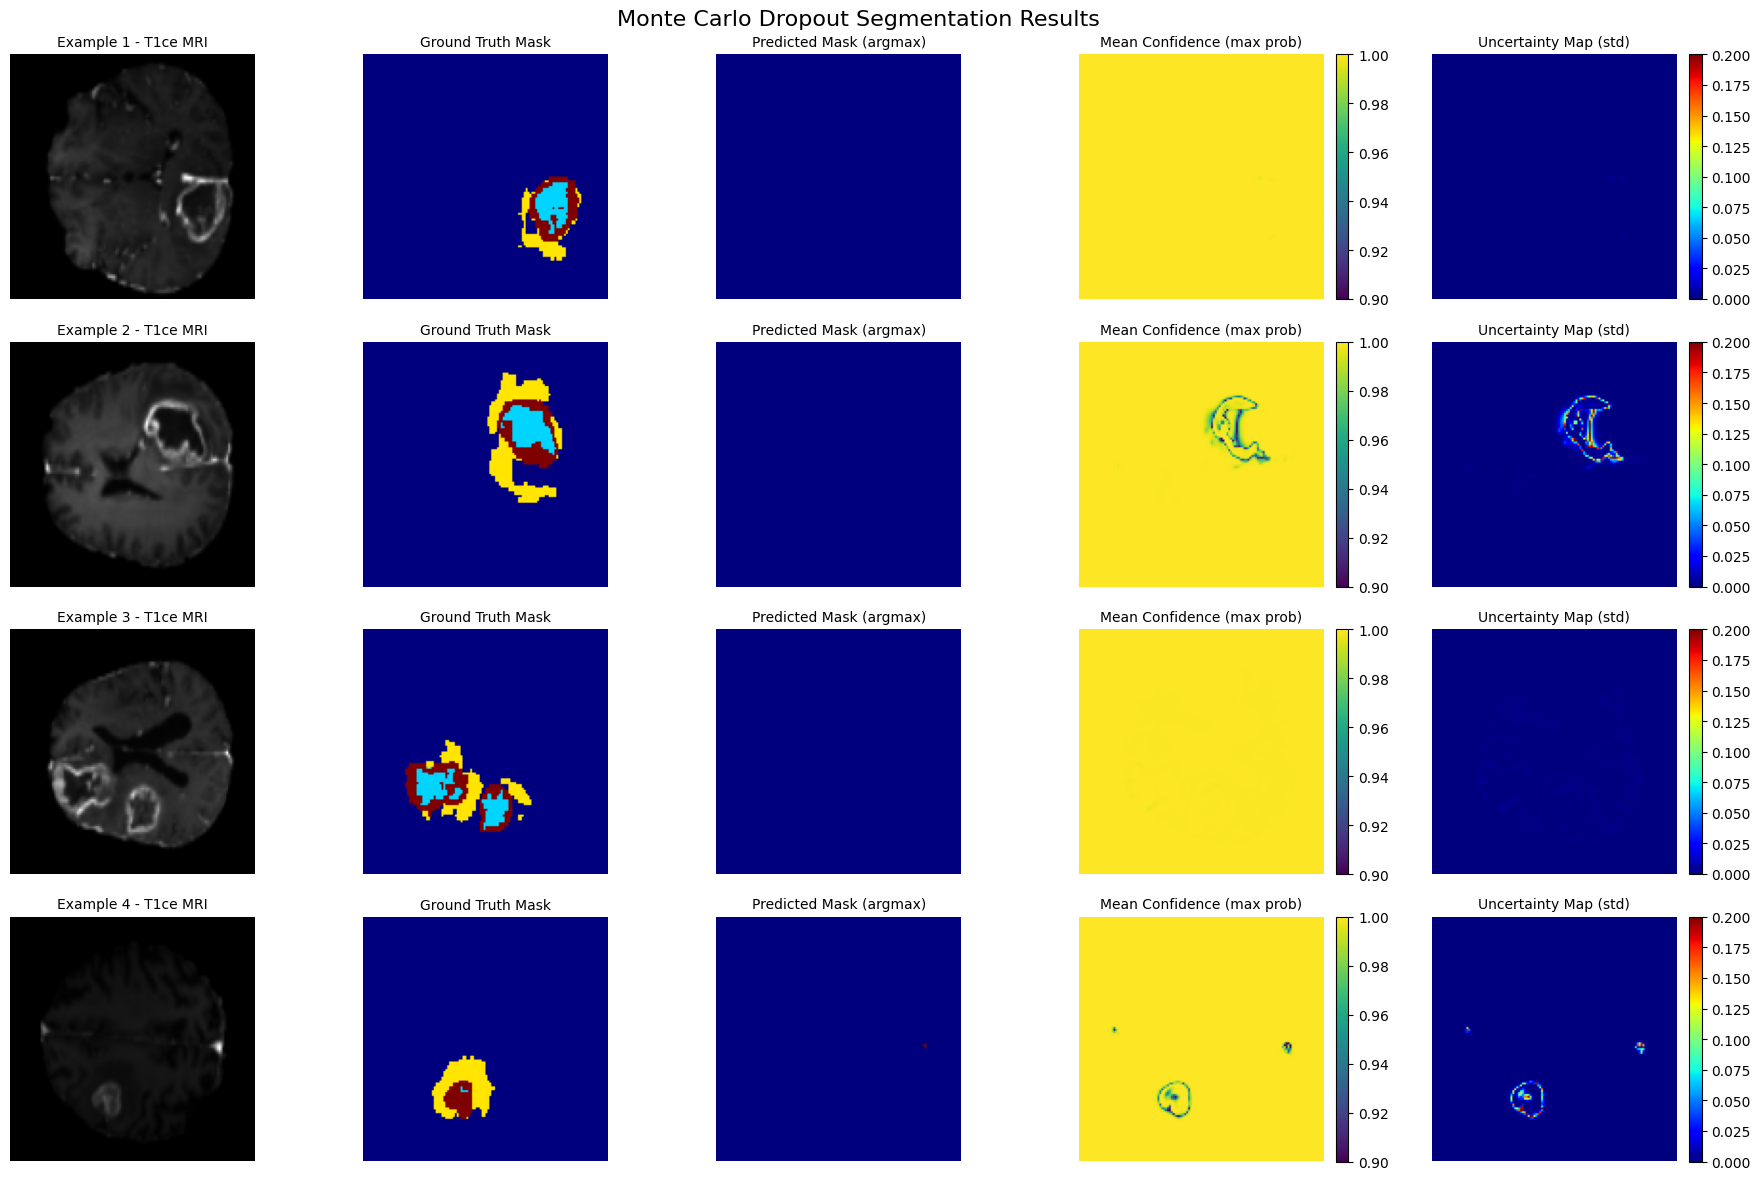

In [119]:
visualize_four_examples(model_bnn, test_loader, device, n_mc=5)

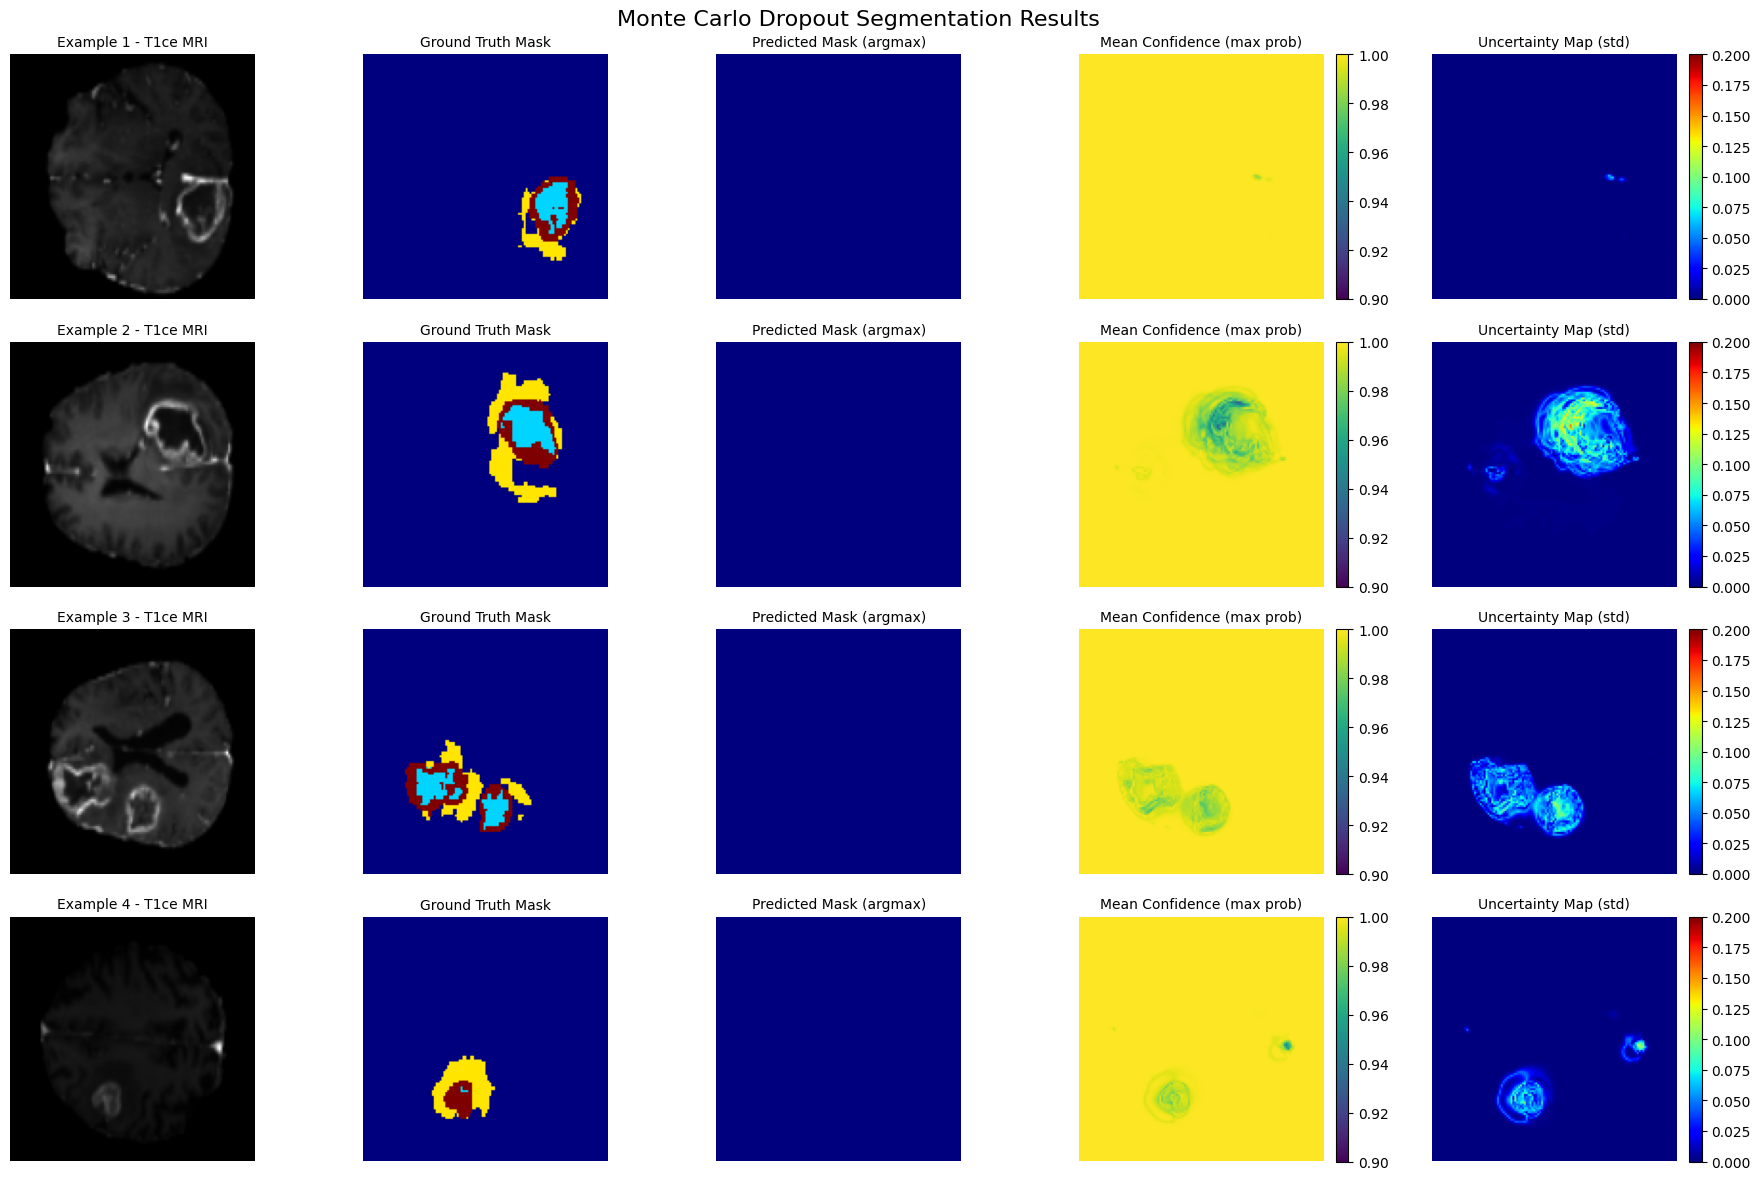

In [120]:
visualize_four_examples(model_bnn, test_loader, device, n_mc=100)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. Once again, the training is far from optimal. The model consistently predicted an all-background mask (class = 0) in every case.

2. However, we can glimpse the potential of the BNN U-Net. When using n_mc = 100, the uncertainty maps provided by the model **take the shape of the tumors**, demonstrating its ability to capture meaningful uncertainty representations!



</div>

### **Conclusion**

#### **<font color='green'>Summary</font>**  

1. **Computing Power and GPU VRAM Limitations**

The **main limiting factor** of our study was the computational power and GPU VRAM. We had access to only **1 to 2 hours of a Google Colab T4 GPU**, which forced us to:
- Reduce the image size.
- Consider only the **T1ce modality** and the reference mask.

Moreover, this limitation prevented us from **finely optimizing the training** of both the CNN and BNN models within the time constraints of this short-term project.

2. **Importance of Data Preprocessing**

Applying **gamma correction and cropping** to our data led to a **50% improvement in model performance**.

3. **CNN Model Training**

The visualization of predicted segmentation masks from the CNN model suggests that **overfitting and lack of generalization** led to the **misclassification of the background as class 1** in certain regions.

4. **Calibration** 

**Monte Carlo Dropout** proved to be the **best calibration method** in our study. However, it could easily be combined with **Temperature Scaling**, which also showed promising results.

Regarding **Adaptive Temperature Scaling (ATS)**, the **instability of the temperature head training**, particularly the **pixel-wise T parameter**, prevents us from fully assessing the robustness of this method. Nevertheless, the temperature maps reveal **significant overconfidence** of the model in tumor regions and misclassified background areas.

5. **Uncertainty Quantification**

Monte Carlo Dropout demonstrated a **strong alignment between confidence maps and uncertainty maps**, which is reassuring since the worst-case scenario would be an **overconfident yet uncertain model**.

The **BNN model**, on the other hand, provides an intriguing insight: **while its predicted masks remain unreliable, its uncertainty maps reveal the shape of the tumor**!

6. **BNN Model Training**

The **BNN model did not train correctly**. Adjustments, such as **tuning the beta parameter**, which controls the weight of the **KL divergence regularization term** in the loss function, are needed to improve training stability.

#### **<font color='blue'>To go further</font>** 

1. **Train a pre-trained model** on MS-Coco images, such as **DeepLab with a ResNet backbone**, and apply the same calibration process.

2. **Train a transformer-based model** such as **ViT (Vision Transformer)** leveraging attention mechanisms, and calibrate it.

3. **Redesign the BNN architecture completely** to explore alternative Bayesian modeling techniques.

4. **Experiment with other calibration methods** like **Platt Scaling or Isotonic Regression**.
